# Coursework: 5 day temperature prediction with time series data

This coursework will build on the work from tutorial 4 which used the 'DailyDelhiClimate' dataset to explore the development of RNN models. The coursework contains 5 tasks each with a number of exercises. The final deliverable of the coursework will be a version of this notebook, including answers to your questions in the appropriate places.

Answers to exercises will take two forms, either code completion or written pros in markdown blocks. Below demonstrates what these will look like:

#### Code completion

In [1]:
# Your code here

# Your code here - END

#### Written pros in markdown

__WRITTEN ANSWER: \<relevant information\>__:

With respect to markdown answers, you may refer to other figures/results/code __within__ the notebook however, this __must__ be stated within the defined answer space. Furthermore, if other figures/results/code are referred to, however, it is not obvious what specific figures/results/code, the references will be discounted from the answer. To load externel images into a jupyter notebook, use the __markdown__ command ```![alt text](<path_to_image_file>)```. And please remember to submit all referenced pictures with your jupyter notebook __within a single zip file__.

__Final points__:
* No marks will be awarded for the performance of models - we are interested in how you approach model development and justify what you are doing!
* There are lots of ways to code something, as long as the code works and produces the desired output, you will be awared full marks (for that question)!

## Setup

In [3]:
gpu = False

# Used for debugging the notebook locally. Leave as False when running in collab!
local_testing = False
if local_testing:
    data_dir = "../../data"
else:
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        data_dir = "/content/drive/MyDrive/comp0188/data"
    except ModuleNotFoundError:
        print("This notebook might be running locally!")


Mounted at /content/drive


In [5]:
import wandb
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
from typing import Union, Callable, Tuple, List, Literal, Dict
from torch.autograd import Variable
import torch.nn as nn
import matplotlib.pyplot as plt
import copy
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import logging
from abc import ABCMeta, abstractmethod

In [6]:
logger = logging.getLogger("coursework_1")
logger.setLevel(logging.INFO)

In [7]:
MODEL_SEED = 1
WANDB_PROJ = "coursework_1"
TMP_DIR = "./tmp"

if os.path.isdir(TMP_DIR):
    pass
else:
    os.mkdir(TMP_DIR)

## Helper functions/classes

In [8]:
class DebugPass:

    def __init__(self):
        self.y_pred = []
        self.y_true = []

    def debug(
        self,
        y_true:torch.tensor,
        y_pred:torch.tensor,
    ):
        pass

    def close(self):
        pass

class DebugBase(DebugPass):

    def __init__(self):
        super().__init__()

    def debug(self, y_true, y_pred):
        self.y_true.append(y_true.detach().numpy())
        self.y_pred.append(y_pred.detach().numpy())

    @abstractmethod
    def close(self):
        pass

class DebugLocal(DebugBase):

    def __init__(self):
        super().__init__()

    def close(self):
        res_tbl = pd.DataFrame(
            {
                "y_true":np.concatenate(self.y_true, axis=0).squeeze().flatten(),
                "y_pred":np.concatenate(self.y_pred, axis=0).squeeze().flatten()
            }
        )
        res_tbl.to_csv(os.path.join(TMP_DIR, "validate_debug.csv"), index=False)

class DebugWandB(DebugBase):

    def __init__(self):
        super().__init__()

    def close(self):
        res_tbl = pd.DataFrame(
            {
                "y_true":np.concatenate(self.y_true, axis=0).squeeze().flatten(),
                "y_pred":np.concatenate(self.y_pred, axis=0).squeeze().flatten()
            }
        )
        wandb_tbl = wandb.Table(dataframe=res_tbl)
        wandb.log({"val_predictions" : wandb_tbl})

def train_single_epoch(model:nn.Module, data_loader:torch.utils.data.DataLoader,
                       gpu:Literal[True, False], optimizer:torch.optim,
                       criterion:torch.nn.modules.loss
                      ) -> Tuple[List[torch.Tensor]]:
    model.train()
    losses = []
    preds = []
    range_gen = tqdm(
        enumerate(data_loader),
        )
    for i, (y,X) in range_gen:

        if gpu:
            X = X.cuda()
            y = y.cuda()
        else:
            X = Variable(X)
            y = Variable(y)

        optimizer.zero_grad()

        # Compute output
        output = model(X)
        preds.append(output)
        train_loss = criterion(output, y)
        losses.append(train_loss.item())

        try:
            train_loss.backward()

            optimizer.step()
        except RuntimeError as e:
            print("Runtime error on training instance: {}".format(i))
            raise e
    return losses, preds

def validate(model:nn.Module, data_loader:torch.utils.data.DataLoader,
             gpu:Literal[True, False], criterion:torch.nn.modules.loss,
             dh:DebugPass
            ) -> Tuple[List[torch.Tensor]]:

    model.eval()
    losses = []
    preds = []
    with torch.no_grad():
        range_gen = tqdm(
            enumerate(data_loader),
        )
        # Your code here
        for i, (y,X) in range_gen:

            if gpu:
                X = X.cuda()
                y = y.cuda()
            else:
                X = Variable(X)
                y = Variable(y)

            # Compute output
            output = model(X)

            # Logs
            losses.append(criterion(output, y).item())
            preds.append(output)
            dh.debug(y_true=y, y_pred=output)
    return losses, preds


def train(model:torch.nn, train_data_loader:torch.utils.data.DataLoader,
          val_data_loader:torch.utils.data.DataLoader,
          gpu:Literal[True, False], optimizer:torch.optim,
          criterion:torch.nn.modules.loss, epochs:int,
          debug:bool = False, wandb_proj:str="",
          wandb_name="", wandb_config:Dict={}
         ) -> Tuple[List[torch.Tensor]]:

    if (len(wandb_config) == 0) or (len(wandb_proj) == 0) or (len(wandb_name) == 0):
        use_wandb = False
        logger.warning("WandB not in use!")
        chkpnt_dir = TMP_DIR
    else:
        use_wandb = True
        wandb.init(project=wandb_proj, config=wandb_config, name=wandb_name)
        chkpnt_dir = wandb.run.dir

    if debug:
        if use_wandb:
            dh = DebugWandB()
        else:
            dh = DebugLocal()
    else:
        dh = DebugPass()

    if gpu:
        model.cuda()

    epoch_train_loss = []
    epoch_val_loss = []
    for epoch in range(1, epochs+1):
        print("Running training epoch")
        train_loss_val, train_preds =  train_single_epoch(
            model=model, data_loader=train_data_loader, gpu=gpu,
            optimizer=optimizer, criterion=criterion)
        mean_train_loss = np.mean(train_loss_val)
        epoch_train_loss.append(mean_train_loss)
        val_loss_val, val_preds = validate(
            model=model, data_loader=val_data_loader, gpu=gpu,
            criterion=criterion, dh=dh)

        print("Running validation")
        mean_val_loss = np.mean(val_loss_val)
        epoch_val_loss.append(np.mean(val_loss_val))

        chkp_pth = os.path.join(chkpnt_dir, f"mdl_chkpnt_epoch_{epoch}.pt")
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, chkp_pth)
        if use_wandb:
            wandb.log({"train_loss": mean_train_loss, "val_loss": mean_val_loss})
            wandb.save(chkp_pth)
    dh.close()
    if use_wandb:
        wandb.finish()
    return epoch_train_loss, epoch_val_loss

In [9]:
class PandasDataset(Dataset):
    def __init__(self, X:pd.DataFrame, y:pd.DataFrame, normalise:bool=True)->None:
        # Your code here
        self._X = torch.from_numpy(X.values).float()
        if normalise:
            self._X = self.__min_max_norm(self._X)
        self.feature_dim = X.shape[1]
        self._len = X.shape[0]
        self._y = torch.from_numpy(y.values).float()

    def __len__(self)->int:
        # Your code here
        return self._len

    def __getitem__(self, idx:int) -> Tuple[torch.Tensor, torch.Tensor]:
        # Your code here
        return self._y[idx], self._X[idx,:]

    def __min_max_norm(self, in_tens:torch.Tensor) -> torch.Tensor:
        _min = in_tens.min(axis=0).values
        _max = in_tens.max(axis=0).values
        in_tens = (in_tens - _min)/(_max - _min)
        return in_tens

class PandasTsDataset(PandasDataset):
    def __init__(self, X:pd.DataFrame, y:pd.DataFrame, lookback:int, normalise:bool=True)->None:
        # Call super so that the PandasDataset.__init__ function is called
        super().__init__(X=X, y=y, normalise=normalise)
        if lookback > 1:
            self.get_lookback(lookback=lookback)
        self._len = self._X.shape[0]

    def get_lookback(self, lookback:int):
        X_vals = []
        y_vals = []
        for i in range(self._X.shape[0]-(lookback-1)):
            X_vals.append(self._X[i:i+lookback][None, :])
            y_vals.append(self._y[i+lookback-1:i+lookback])
        self._y = torch.concat(y_vals, axis=0)
        self._X = torch.concat(X_vals, axis=0)


## Data import and visualisation
This section contains code for loading the data and generating different target values. This is the same code that was used in tutorial 4.

In [10]:
train_df = pd.read_csv(os.path.join(data_dir, "DailyDelhiClimateTrain.csv"))
test_df = pd.read_csv(os.path.join(data_dir, "DailyDelhiClimateTest.csv"))
date_var = "date"
train_df[date_var] = pd.to_datetime(train_df[date_var], format="%Y-%m-%d")

# Dynamically select remaining columns
non_date_vars = [col for col in train_df.columns if col != date_var]
# For the training and test set, create a new column per non-date variable for each step number in "steps"
steps = [1,5,10]
for df in [train_df, test_df]:
    for stp in steps:
        df[[f"{col}_{stp}_step" for col in non_date_vars]] = df[non_date_vars].shift(-1*stp)
train_df["__date_yrs"] = train_df["date"].dt.year
# Visualise time periods covered by the training data
print(train_df["__date_yrs"].value_counts())

# Select the time period for the holdout set
val_idx = train_df["__date_yrs"] >= 2016
val_df = train_df[val_idx].drop(columns=[col for col in train_df.columns if col[0:2] == "__"])
train_df = train_df[~val_idx].drop(columns=[col for col in train_df.columns if col[0:2] == "__"])
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
train_df.head()

2016    366
2013    365
2014    365
2015    365
2017      1
Name: __date_yrs, dtype: int64
(1095, 17)
(367, 17)
(114, 17)


,date,meantemp,humidity,wind_speed,meanpressure,meantemp_1_step,humidity_1_step,wind_speed_1_step,meanpressure_1_step,meantemp_5_step,humidity_5_step,wind_speed_5_step,meanpressure_5_step,meantemp_10_step,humidity_10_step,wind_speed_10_step,meanpressure_10_step
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,7.400000,92.000000,2.980000,1017.800000,7.000000,82.800000,1.480000,1018.000000,15.714286,51.285714,10.571429,1016.142857
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,7.166667,87.000000,4.633333,1018.666667,7.000000,78.600000,6.300000,1020.000000,14.000000,74.000000,13.228571,1015.571429
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,8.666667,71.333333,1.233333,1017.166667,8.857143,63.714286,7.142857,1018.714286,15.833333,75.166667,4.633333,1013.333333
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,6.000000,86.833333,3.700000,1016.500000,14.000000,51.250000,12.500000,1017.000000,12.833333,88.166667,0.616667,1015.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,7.000000,82.800000,1.480000,1018.000000,11.000000,62.000000,7.400000,1015.666667,14.714286,71.857143,0.528571,1015.857143


## Task1: Project assumptions

Before performing any kind of model development, it is critical to define the scope of the model development process. This includes making decisions which stay fixed throughout the rest of the model development as changing them would render model comparisons invalid. For example, comparing two models with test score calculated on different test datasets or with different metrics is meaningless. These decisions are herein referred to as "model development assumptions" and include but are not limited to:
* The split of training/validation and test set;
* Overall model performance metric need to be defined.

Whilst these assumptions can be altered later on in the model development process, they have been sectioned here to emphasise their importance and impact on the subsiquent process i.e., don't be afraid to edit them but understand the impact that this will have on any subsiquent development that you have performed!

__Exercise 1.1__ (1 mark):
* Provide in the code block below a reasonable model performance metric which will be used to report the performance of the baseline model and subsiquent model experiements.
* Justify your choice of criterion. Reference should be made to the theoretical range of values over which the target variable is defined.

In [11]:
# Your code here
ovrl_criterion = nn.MSELoss() # mean squared error
# Your code here - END
trgt_col = ["meantemp_5_step"]

__```ovrl_criterion``` Justification__: this is an autoregressive task, and the target column consists of a continuous variable with a theoretical range of values $\text{}meantemp\_5\_step \in [0, +\infty]$, so it is suitable to use the MSE. Furthermore, as shown in the plot below the target variable follows a Gaussian-like distribution, with a right skew. I can therefore reasonably assume it can be modelled via a Gaussian likelihood from which the MSE can be derived.

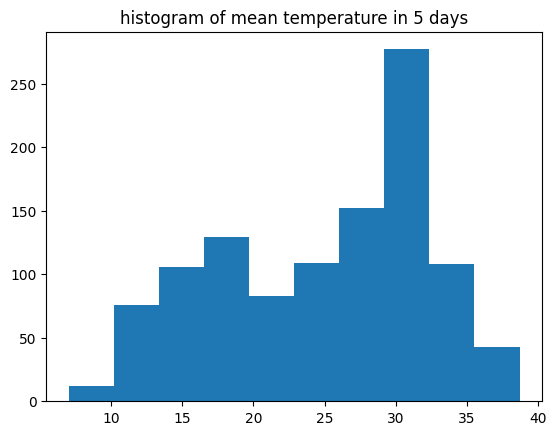

In [13]:
plt.hist(train_df['meantemp_5_step'])
plt.title("histogram of mean temperature in 5 days")
plt.show()

## Task2: Baseline model
Now that the project assumptions have been set, a baseline model must be defined to guide the development of more complex models. The baseline model for the task should be of the form $y_{t+5} = b + x_{t}w_{1}^{T} + x_{t-1}w_{2}^{T}$, where:
* $y_{t}$ is vector of dimension (1), represeting the mean temperature at time t
* $x_{t}$ is a vector of dimension (1, 4) representing the mean temperature, mean pressure, etc (note, therefore $y_{t} \in x_{t}$)
* $W_{1}$ and $W_{2}$ are weight vectors of dimension (1, 4) and $b$ is a bias term of dimension (1)

Note, the dimensions above __do not include__ a batch dimension

__Exercise 2.1__ (4 marks):
* Implement the above baseline model in Pytorch

_Hint_:
* Remember, MLPs are just a series of linear regressions chained together with non-linear activations. Given this, what PyTorch module might be useful to use?
* How you would compute $x_{t}w_{1}^{T}$ on paper - this may provide insight into how the above baseline equation can be simplified and implemented in Pytorch
* Remember, for Pytorch models, the ```forward``` method implements the forward pass of the model and _generally speaking_ refers to modules that have been initialised within the class ```__init__```

In [14]:
class BaselineModel(nn.Module):
    def __init__(self, input_dim:int, output_dim:int) -> None:
        torch.manual_seed(MODEL_SEED)
        super().__init__()
        # Your code here
        '''
        The above model is essentially :
        y = b + w1 * x1^t + w2 * x2^t + w3 * x3^t + w4 * x4^t +
            w5 * x5^t-1 + w6 * x6^t-1 + w7 * x7^t-1 + w8 * x8^t-1
        '''
        self.in_dim = input_dim
        self.fc = nn.Linear(in_features=2 * input_dim, out_features=output_dim, bias=True)

        # Your code here - END

    def forward(self, x:torch.tensor)->torch.tensor:
        # Your code here
        '''
        x: a torch tensor of size (2, 4), where x[0] would be x_t and
        x[1] would be x_{t-1}

        '''
        if len(x.shape) != 3:
            # if the shape of x is not (batch, lookback, features), then
            # add a batch dimension
            x = x[None, :]
        x = torch.flatten(x, start_dim=1) # flatten from (2,4) to (1, 8)
        out = self.fc(x)
        return out.squeeze()
        # Your code here - END

__Exercise 2.2__: (1 marks)
* In the code block below, define some reasonable hyperparameters for training your baseline model. For each of the hyperparameters, justify your choices using the markdown block below the code block.

_Hint_:
* ```lookback``` and ```input_dim``` should be set to specific values using information that you have already been provided with
* ```shuffle```, ```batch_size``` and ```lr``` should be set to values deemed reasonable by you.
    * Remember, for __some__ of these parameters, setting a value that is generally understood to work might be a good starting point. However, the hyperparameters chosen need to work for our baseline model!

In [17]:
# Your code here
indp_cols = [ # code from lab 4 to fetch 4 features
    col for col in train_df.columns if (
        (col != date_var) and (col[-5:] != "_step")
    )
]
lookback = 2
input_dim = len(indp_cols)
shuffle=True
batch_size = 32 # a power of 2
lr = 0.01
# Your code here - END
epochs = 100

__WRITTEN ANSWER: ```lookback``` justification__: I want to look at 2 rows $x_t$ and $x_{t + 1}$ to predict $y_{t+5}$

__WRITTEN ANSWER: ```input_dim``` justification__: there are 4 features

__WRITTEN ANSWER: ```shuffle``` justification__: it is standard procedure to shuffle the dataloader (not shuffling this dataset) to make gradient descent stochastic, guaranteeing hitting a minimum of the loss.

__WRITTEN ANSWER: ```batch_size``` justification__: empirically, I've seen people use powers of 2. Since this is a very small dataset, with just a few 1000 or so datapoints, $2^5$ is reasonable.

__WRITTEN ANSWER: ```lr``` justification__: I would have preferred cosine annealing. But for a small dataset, I don't have to worry on slow convergence coupled with a reasonably big batch size so I can try a small lr to guarantee not overshooting a minimum in the loss.

In [18]:
train_dataset = PandasTsDataset(X=train_df[non_date_vars], y=train_df[trgt_col], lookback=lookback)
val_idx = val_df[trgt_col].isna().sum(axis=1) != 1
val_dataset = PandasTsDataset(X=val_df[val_idx][non_date_vars], y=val_df[val_idx][trgt_col], lookback=lookback)
train_loader = DataLoader(dataset=train_dataset, shuffle=shuffle, batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, shuffle=shuffle, batch_size=batch_size)

In [19]:
wandb_config={
    "lr": lr,
    "lookback": lookback,
}

model = BaselineModel(input_dim=input_dim, output_dim=1)

# Check model parameters
for param in model.named_parameters():
    print(f"Param: {param[0]}")
    print(f"Param shape: {param[1].shape}")
    print("\n")

# Check model is predicting
with torch.no_grad():
    first_batch = next(train_loader.__iter__())
    res = model(first_batch[1])
    print(f"first_batch res shape: {first_batch[0].shape}")
    print(f"res shape: {res.shape}")

optimizer=torch.optim.Adam(model.parameters(), lr=wandb_config["lr"])
epoch_train_loss, epoch_val_loss = train(
    model=model, train_data_loader=train_loader, val_data_loader=val_loader, gpu = gpu,
    optimizer=optimizer, criterion=ovrl_criterion, epochs=epochs,
    wandb_proj=WANDB_PROJ, wandb_name="baseline", wandb_config=wandb_config, debug=False
)

Param: fc.weight
Param shape: torch.Size([1, 8])


Param: fc.bias
Param shape: torch.Size([1])


first_batch res shape: torch.Size([32, 1])
res shape: torch.Size([32])


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Running training epoch


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
14it [00:00, 130.05it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([6, 1])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
35it [00:00, 212.21it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([9, 1])) that is different to the input size (torch.Size([9])). This will likely lead to incorrect results due t

Running validation
Running training epoch


35it [00:00, 678.29it/s]
12it [00:00, 955.19it/s]


Running validation
Running training epoch


35it [00:00, 452.34it/s]
12it [00:00, 444.13it/s]


Running validation
Running training epoch


35it [00:00, 425.55it/s]
12it [00:00, 606.03it/s]


Running validation
Running training epoch


35it [00:00, 351.27it/s]
12it [00:00, 810.34it/s]


Running validation
Running training epoch


35it [00:00, 401.85it/s]
12it [00:00, 259.12it/s]


Running validation
Running training epoch


35it [00:00, 369.59it/s]
12it [00:00, 762.17it/s]


Running validation
Running training epoch


35it [00:00, 451.88it/s]
12it [00:00, 672.25it/s]


Running validation
Running training epoch


35it [00:00, 404.55it/s]
12it [00:00, 625.56it/s]


Running validation
Running training epoch


35it [00:00, 439.78it/s]
12it [00:00, 864.12it/s]


Running validation
Running training epoch


35it [00:00, 566.20it/s]
12it [00:00, 1080.98it/s]


Running validation
Running training epoch


35it [00:00, 555.53it/s]
12it [00:00, 897.58it/s]


Running validation
Running training epoch


35it [00:00, 439.36it/s]
12it [00:00, 831.60it/s]


Running validation
Running training epoch


35it [00:00, 444.67it/s]
12it [00:00, 907.79it/s]


Running validation
Running training epoch


35it [00:00, 682.17it/s]
12it [00:00, 928.18it/s]


Running validation
Running training epoch


35it [00:00, 695.84it/s]
12it [00:00, 872.74it/s]


Running validation
Running training epoch


35it [00:00, 727.93it/s]
12it [00:00, 752.78it/s]


Running validation
Running training epoch


35it [00:00, 595.85it/s]
12it [00:00, 641.91it/s]


Running validation
Running training epoch


35it [00:00, 597.29it/s]
12it [00:00, 607.79it/s]


Running validation
Running training epoch


35it [00:00, 646.30it/s]
12it [00:00, 959.32it/s]


Running validation
Running training epoch


35it [00:00, 671.38it/s]
12it [00:00, 836.44it/s]


Running validation
Running training epoch


35it [00:00, 618.70it/s]
12it [00:00, 646.41it/s]


Running validation
Running training epoch


35it [00:00, 579.76it/s]
12it [00:00, 903.54it/s]


Running validation
Running training epoch


35it [00:00, 749.38it/s]
12it [00:00, 1165.62it/s]


Running validation
Running training epoch


35it [00:00, 641.80it/s]
12it [00:00, 550.17it/s]


Running validation
Running training epoch


35it [00:00, 646.95it/s]
12it [00:00, 887.82it/s]


Running validation
Running training epoch


35it [00:00, 625.33it/s]
12it [00:00, 852.07it/s]


Running validation
Running training epoch


35it [00:00, 672.28it/s]
12it [00:00, 854.47it/s]


Running validation
Running training epoch


35it [00:00, 454.04it/s]
12it [00:00, 900.03it/s]


Running validation
Running training epoch


35it [00:00, 593.04it/s]
12it [00:00, 701.69it/s]


Running validation
Running training epoch


35it [00:00, 523.33it/s]
12it [00:00, 866.82it/s]


Running validation
Running training epoch


35it [00:00, 639.39it/s]
12it [00:00, 890.89it/s]

Running validation


Running training epoch


35it [00:00, 629.30it/s]
12it [00:00, 1245.28it/s]


Running validation
Running training epoch


35it [00:00, 614.77it/s]
12it [00:00, 941.01it/s]


Running validation
Running training epoch


35it [00:00, 526.10it/s]
12it [00:00, 751.14it/s]

Running validation


Running training epoch


35it [00:00, 743.10it/s]
12it [00:00, 837.77it/s]


Running validation
Running training epoch


35it [00:00, 625.85it/s]
12it [00:00, 882.05it/s]


Running validation
Running training epoch


35it [00:00, 543.20it/s]
12it [00:00, 806.08it/s]


Running validation
Running training epoch


35it [00:00, 660.67it/s]
12it [00:00, 1265.38it/s]

Running validation


Running training epoch


35it [00:00, 657.48it/s]
12it [00:00, 984.71it/s]


Running validation
Running training epoch


35it [00:00, 559.65it/s]
12it [00:00, 932.41it/s]


Running validation
Running training epoch


35it [00:00, 638.81it/s]
12it [00:00, 636.87it/s]


Running validation
Running training epoch


35it [00:00, 567.43it/s]
12it [00:00, 812.63it/s]


Running validation
Running training epoch


35it [00:00, 645.28it/s]
12it [00:00, 934.25it/s]


Running validation
Running training epoch


35it [00:00, 651.91it/s]
12it [00:00, 771.99it/s]


Running validation
Running training epoch


35it [00:00, 677.02it/s]
12it [00:00, 1108.09it/s]


Running validation
Running training epoch


35it [00:00, 674.02it/s]
12it [00:00, 771.27it/s]


Running validation
Running training epoch


35it [00:00, 742.52it/s]
12it [00:00, 676.15it/s]


Running validation
Running training epoch


35it [00:00, 598.32it/s]
12it [00:00, 907.94it/s]


Running validation
Running training epoch


35it [00:00, 637.79it/s]
12it [00:00, 886.95it/s]


Running validation
Running training epoch


35it [00:00, 389.47it/s]
12it [00:00, 639.81it/s]


Running validation
Running training epoch


35it [00:00, 479.52it/s]
12it [00:00, 697.67it/s]


Running validation
Running training epoch


35it [00:00, 408.89it/s]
12it [00:00, 781.58it/s]


Running validation
Running training epoch


35it [00:00, 538.96it/s]
12it [00:00, 504.46it/s]


Running validation
Running training epoch


35it [00:00, 415.66it/s]
12it [00:00, 586.05it/s]


Running validation
Running training epoch


35it [00:00, 458.14it/s]
12it [00:00, 608.05it/s]


Running validation
Running training epoch


35it [00:00, 412.57it/s]
12it [00:00, 673.65it/s]


Running validation
Running training epoch


35it [00:00, 377.45it/s]
12it [00:00, 541.74it/s]


Running validation
Running training epoch


35it [00:00, 378.18it/s]
12it [00:00, 653.59it/s]


Running validation
Running training epoch


35it [00:00, 421.40it/s]
12it [00:00, 598.46it/s]


Running validation
Running training epoch


35it [00:00, 382.71it/s]
12it [00:00, 867.76it/s]


Running validation
Running training epoch


35it [00:00, 414.50it/s]
12it [00:00, 637.83it/s]


Running validation
Running training epoch


35it [00:00, 415.39it/s]
12it [00:00, 505.77it/s]


Running validation
Running training epoch


35it [00:00, 447.80it/s]
12it [00:00, 879.45it/s]


Running validation
Running training epoch


35it [00:00, 384.68it/s]
12it [00:00, 562.78it/s]


Running validation
Running training epoch


35it [00:00, 312.54it/s]
12it [00:00, 814.67it/s]


Running validation
Running training epoch


35it [00:00, 246.79it/s]
12it [00:00, 809.58it/s]


Running validation
Running training epoch


35it [00:00, 397.73it/s]
12it [00:00, 725.27it/s]


Running validation
Running training epoch


35it [00:00, 435.24it/s]
12it [00:00, 726.57it/s]


Running validation
Running training epoch


35it [00:00, 385.42it/s]
12it [00:00, 829.79it/s]


Running validation
Running training epoch


35it [00:00, 387.96it/s]
12it [00:00, 597.25it/s]


Running validation
Running training epoch


35it [00:00, 291.77it/s]
12it [00:00, 596.33it/s]


Running validation
Running training epoch


35it [00:00, 283.68it/s]
12it [00:00, 806.02it/s]


Running validation
Running training epoch


35it [00:00, 419.32it/s]
12it [00:00, 775.45it/s]


Running validation
Running training epoch


35it [00:00, 451.70it/s]
12it [00:00, 867.31it/s]


Running validation
Running training epoch


35it [00:00, 444.89it/s]
12it [00:00, 683.21it/s]


Running validation
Running training epoch


35it [00:00, 432.17it/s]
12it [00:00, 488.13it/s]


Running validation
Running training epoch


35it [00:00, 404.83it/s]
12it [00:00, 631.48it/s]


Running validation
Running training epoch


35it [00:00, 394.31it/s]
12it [00:00, 729.15it/s]


Running validation
Running training epoch


35it [00:00, 434.12it/s]
12it [00:00, 538.46it/s]


Running validation
Running training epoch


35it [00:00, 285.53it/s]
12it [00:00, 829.35it/s]


Running validation
Running training epoch


35it [00:00, 460.26it/s]
12it [00:00, 853.24it/s]


Running validation
Running training epoch


35it [00:00, 381.39it/s]
12it [00:00, 539.54it/s]


Running validation
Running training epoch


35it [00:00, 397.63it/s]
12it [00:00, 616.76it/s]


Running validation
Running training epoch


35it [00:00, 469.90it/s]
12it [00:00, 551.36it/s]


Running validation
Running training epoch


35it [00:00, 388.86it/s]
12it [00:00, 873.57it/s]


Running validation
Running training epoch


35it [00:00, 387.94it/s]
12it [00:00, 873.33it/s]


Running validation
Running training epoch


35it [00:00, 354.46it/s]
12it [00:00, 688.85it/s]


Running validation
Running training epoch


35it [00:00, 343.36it/s]
12it [00:00, 457.55it/s]


Running validation
Running training epoch


35it [00:00, 137.64it/s]
12it [00:00, 579.62it/s]


Running validation
Running training epoch


35it [00:00, 297.18it/s]
12it [00:00, 676.40it/s]


Running validation
Running training epoch


35it [00:00, 378.53it/s]
12it [00:00, 552.16it/s]


Running validation
Running training epoch


35it [00:00, 412.11it/s]
12it [00:00, 521.59it/s]


Running validation
Running training epoch


35it [00:00, 356.83it/s]
12it [00:00, 531.18it/s]


Running validation
Running training epoch


35it [00:00, 421.17it/s]
12it [00:00, 769.29it/s]


Running validation
Running training epoch


35it [00:00, 433.23it/s]
12it [00:00, 650.83it/s]


Running validation
Running training epoch


35it [00:00, 407.10it/s]
12it [00:00, 543.45it/s]


Running validation
Running training epoch


35it [00:00, 428.72it/s]
12it [00:00, 729.39it/s]


Running validation
Running training epoch


35it [00:00, 439.81it/s]
12it [00:00, 534.60it/s]


Running validation
Running training epoch


35it [00:00, 386.38it/s]
12it [00:00, 484.19it/s]


Running validation


train_loss,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,55.94103
val_loss,77.34032


In [20]:
# save for later use
baseline_train_loss, baseline_val_loss = epoch_train_loss, epoch_val_loss

## Task3: First deep learning model

Given the sequential nature of dataset, an RNN model will be developed for the first stage of the model development process. The ```VanillaRNN``` class below defines such a model blueprint.

In [21]:
class VanillaRNN(nn.Module):

    def __init__(self, input_dim:int,  hidden_dim:int, num_layers:int,
                 fc_output_size:int, *args, **kwargs) -> None:
        torch.manual_seed(MODEL_SEED)
        super().__init__()
        self._num_layers = num_layers
        self._hidden_dim = hidden_dim
        self.rnn = nn.RNN(
            input_size=input_dim,  hidden_size=hidden_dim,
            num_layers=num_layers, *args, **kwargs,
            batch_first=True
        )
        self.fc = nn.Linear(in_features=hidden_dim, out_features=fc_output_size)

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out = self.rnn(x, hidden)
        return self.fc(out[1].squeeze())

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self._num_layers, batch_size, self._hidden_dim)
        return hidden


__Exercise 3.1:__ (1 marks)
* Complete the code block below, defining the hyperparameters which will be used to define a model of type ```VanillaRNN``` according to the following model specification:
    * A hidden dimension of 64;
    * A single RNN layer with a linear output head and;
    * Relu activations

In [23]:
# Your code here
input_dim = len(indp_cols)
hidden_dim = 64 #
num_layers = 1
nonlinearity = 'relu'
# Your code here - END
fc_output_size = len(trgt_col)

In [24]:
wandb_config={
    "lr": lr,
    "lookback": lookback,
    "hidden_dim": hidden_dim,
    "num_layers": num_layers,
    "nonlinearity": nonlinearity,
    "fc_output_size": fc_output_size
}

model = VanillaRNN(
    input_dim=input_dim,  hidden_dim=wandb_config["hidden_dim"],
    num_layers=wandb_config["num_layers"], fc_output_size=wandb_config["fc_output_size"],
    nonlinearity=wandb_config["nonlinearity"]
)

first_batch = next(train_loader.__iter__())
with torch.no_grad():
    print(first_batch[0].shape)
    print(model(first_batch[1]).shape)

optimizer=torch.optim.Adam(model.parameters(), lr=wandb_config["lr"])
epoch_train_loss, epoch_val_loss = train(
    model=model, train_data_loader=train_loader, val_data_loader=val_loader, gpu = gpu,
    optimizer=optimizer, criterion=ovrl_criterion, epochs=epochs,
    wandb_proj=WANDB_PROJ, wandb_name="vanillaRNN", wandb_config=wandb_config, debug=False
)

wandb: Currently logged in as: anwangxuelong (cell-x). Use `wandb login --relogin` to force relogin


torch.Size([32, 1])
torch.Size([32, 1])


Running training epoch


35it [00:00, 183.79it/s]
12it [00:00, 265.09it/s]


Running validation
Running training epoch


35it [00:00, 127.66it/s]
12it [00:00, 730.90it/s]


Running validation
Running training epoch


35it [00:00, 244.11it/s]
12it [00:00, 307.57it/s]


Running validation
Running training epoch


35it [00:00, 96.20it/s] 
12it [00:00, 322.70it/s]


Running validation
Running training epoch


35it [00:00, 169.02it/s]
12it [00:00, 737.77it/s]


Running validation
Running training epoch


35it [00:00, 154.09it/s]
12it [00:00, 655.10it/s]


Running validation
Running training epoch


35it [00:00, 182.51it/s]
12it [00:00, 713.77it/s]


Running validation
Running training epoch


35it [00:00, 238.67it/s]
12it [00:00, 695.92it/s]


Running validation
Running training epoch


35it [00:00, 272.12it/s]
12it [00:00, 653.14it/s]


Running validation
Running training epoch


35it [00:00, 267.86it/s]
12it [00:00, 542.38it/s]


Running validation
Running training epoch


35it [00:00, 219.11it/s]
12it [00:00, 659.66it/s]

Running validation


Running training epoch


35it [00:00, 242.58it/s]
12it [00:00, 616.66it/s]


Running validation
Running training epoch


35it [00:00, 258.20it/s]
12it [00:00, 653.94it/s]


Running validation
Running training epoch


35it [00:00, 239.47it/s]
12it [00:00, 638.85it/s]


Running validation
Running training epoch


35it [00:00, 235.02it/s]
12it [00:00, 665.02it/s]


Running validation
Running training epoch


35it [00:00, 228.11it/s]
12it [00:00, 589.34it/s]

Running validation


Running training epoch


35it [00:00, 251.71it/s]
12it [00:00, 896.38it/s]


Running validation
Running training epoch


35it [00:00, 376.61it/s]
12it [00:00, 847.59it/s]


Running validation
Running training epoch


35it [00:00, 381.49it/s]
12it [00:00, 681.39it/s]


Running validation
Running training epoch


35it [00:00, 412.39it/s]
12it [00:00, 867.82it/s]


Running validation
Running training epoch


35it [00:00, 375.46it/s]
12it [00:00, 874.28it/s]


Running validation
Running training epoch


35it [00:00, 374.46it/s]
12it [00:00, 752.24it/s]


Running validation
Running training epoch


35it [00:00, 230.58it/s]
12it [00:00, 645.51it/s]


Running validation
Running training epoch


35it [00:00, 407.76it/s]
12it [00:00, 836.73it/s]


Running validation
Running training epoch


35it [00:00, 419.47it/s]
12it [00:00, 814.82it/s]


Running validation
Running training epoch


35it [00:00, 412.41it/s]
12it [00:00, 805.10it/s]


Running validation
Running training epoch


35it [00:00, 437.02it/s]
12it [00:00, 790.68it/s]


Running validation
Running training epoch


35it [00:00, 379.92it/s]
12it [00:00, 857.37it/s]


Running validation
Running training epoch


35it [00:00, 398.64it/s]
12it [00:00, 668.41it/s]


Running validation
Running training epoch


35it [00:00, 315.36it/s]
12it [00:00, 926.82it/s]


Running validation
Running training epoch


35it [00:00, 318.53it/s]
12it [00:00, 741.80it/s]


Running validation
Running training epoch


35it [00:00, 334.72it/s]
12it [00:00, 722.74it/s]


Running validation
Running training epoch


35it [00:00, 380.69it/s]
12it [00:00, 749.51it/s]


Running validation
Running training epoch


35it [00:00, 355.76it/s]
12it [00:00, 803.63it/s]


Running validation
Running training epoch


35it [00:00, 325.90it/s]
12it [00:00, 878.28it/s]


Running validation
Running training epoch


35it [00:00, 329.95it/s]
12it [00:00, 675.84it/s]


Running validation
Running training epoch


35it [00:00, 300.62it/s]
12it [00:00, 1035.87it/s]


Running validation
Running training epoch


35it [00:00, 320.03it/s]
12it [00:00, 870.67it/s]


Running validation
Running training epoch


35it [00:00, 303.84it/s]
12it [00:00, 909.02it/s]


Running validation
Running training epoch


35it [00:00, 355.98it/s]
12it [00:00, 741.82it/s]


Running validation
Running training epoch


35it [00:00, 389.20it/s]
12it [00:00, 723.17it/s]


Running validation
Running training epoch


35it [00:00, 290.80it/s]
12it [00:00, 755.37it/s]


Running validation
Running training epoch


35it [00:00, 260.67it/s]
12it [00:00, 485.84it/s]


Running validation
Running training epoch


35it [00:00, 365.27it/s]
12it [00:00, 794.34it/s]


Running validation
Running training epoch


35it [00:00, 428.25it/s]
12it [00:00, 746.99it/s]


Running validation
Running training epoch


35it [00:00, 352.78it/s]
12it [00:00, 670.59it/s]


Running validation
Running training epoch


35it [00:00, 394.94it/s]
12it [00:00, 843.58it/s]


Running validation
Running training epoch


35it [00:00, 322.64it/s]
12it [00:00, 934.04it/s]


Running validation
Running training epoch


35it [00:00, 374.73it/s]
12it [00:00, 800.91it/s]


Running validation
Running training epoch


35it [00:00, 359.61it/s]
12it [00:00, 729.98it/s]


Running validation
Running training epoch


35it [00:00, 373.70it/s]
12it [00:00, 776.18it/s]


Running validation
Running training epoch


35it [00:00, 382.33it/s]
12it [00:00, 793.87it/s]


Running validation
Running training epoch


35it [00:00, 406.16it/s]
12it [00:00, 849.42it/s]


Running validation
Running training epoch


35it [00:00, 401.76it/s]
12it [00:00, 725.44it/s]


Running validation
Running training epoch


35it [00:00, 401.36it/s]
12it [00:00, 709.58it/s]


Running validation
Running training epoch


35it [00:00, 426.69it/s]
12it [00:00, 862.48it/s]


Running validation
Running training epoch


35it [00:00, 390.13it/s]
12it [00:00, 856.10it/s]


Running validation
Running training epoch


35it [00:00, 353.70it/s]
12it [00:00, 663.10it/s]


Running validation
Running training epoch


35it [00:00, 359.21it/s]
12it [00:00, 982.23it/s]


Running validation
Running training epoch


35it [00:00, 353.08it/s]
12it [00:00, 707.71it/s]


Running validation
Running training epoch


35it [00:00, 417.79it/s]
12it [00:00, 634.21it/s]


Running validation
Running training epoch


35it [00:00, 373.99it/s]
12it [00:00, 681.33it/s]


Running validation
Running training epoch


35it [00:00, 368.87it/s]
12it [00:00, 702.39it/s]


Running validation
Running training epoch


35it [00:00, 381.41it/s]
12it [00:00, 748.64it/s]


Running validation
Running training epoch


35it [00:00, 402.21it/s]
12it [00:00, 770.23it/s]


Running validation
Running training epoch


35it [00:00, 369.85it/s]
12it [00:00, 907.84it/s]


Running validation
Running training epoch


35it [00:00, 345.95it/s]
12it [00:00, 827.07it/s]


Running validation
Running training epoch


35it [00:00, 412.43it/s]
12it [00:00, 918.08it/s]


Running validation
Running training epoch


35it [00:00, 365.79it/s]
12it [00:00, 684.64it/s]


Running validation
Running training epoch


35it [00:00, 373.17it/s]
12it [00:00, 899.10it/s]


Running validation
Running training epoch


35it [00:00, 361.31it/s]
12it [00:00, 834.41it/s]


Running validation
Running training epoch


35it [00:00, 394.08it/s]
12it [00:00, 801.73it/s]


Running validation
Running training epoch


35it [00:00, 311.89it/s]
12it [00:00, 932.97it/s]


Running validation
Running training epoch


35it [00:00, 365.14it/s]
12it [00:00, 842.20it/s]


Running validation
Running training epoch


35it [00:00, 401.81it/s]
12it [00:00, 753.24it/s]


Running validation
Running training epoch


35it [00:00, 404.64it/s]
12it [00:00, 833.86it/s]


Running validation
Running training epoch


35it [00:00, 361.20it/s]
12it [00:00, 724.20it/s]


Running validation
Running training epoch


35it [00:00, 351.71it/s]
12it [00:00, 742.40it/s]


Running validation
Running training epoch


35it [00:00, 378.34it/s]
12it [00:00, 783.91it/s]


Running validation
Running training epoch


35it [00:00, 382.44it/s]
12it [00:00, 473.69it/s]


Running validation
Running training epoch


35it [00:00, 402.49it/s]
12it [00:00, 724.79it/s]


Running validation
Running training epoch


35it [00:00, 401.85it/s]
12it [00:00, 612.05it/s]


Running validation
Running training epoch


35it [00:00, 384.87it/s]
12it [00:00, 1040.15it/s]


Running validation
Running training epoch


35it [00:00, 403.78it/s]
12it [00:00, 762.76it/s]


Running validation
Running training epoch


35it [00:00, 417.65it/s]
12it [00:00, 855.76it/s]


Running validation
Running training epoch


35it [00:00, 396.97it/s]
12it [00:00, 805.22it/s]


Running validation
Running training epoch


35it [00:00, 349.45it/s]
12it [00:00, 451.23it/s]


Running validation
Running training epoch


35it [00:00, 240.33it/s]
12it [00:00, 542.64it/s]


Running validation
Running training epoch


35it [00:00, 251.43it/s]
12it [00:00, 486.00it/s]


Running validation
Running training epoch


35it [00:00, 225.49it/s]
12it [00:00, 690.83it/s]


Running validation
Running training epoch


35it [00:00, 233.46it/s]
12it [00:00, 667.53it/s]


Running validation
Running training epoch


35it [00:00, 257.15it/s]
12it [00:00, 681.19it/s]


Running validation
Running training epoch


35it [00:00, 232.62it/s]
12it [00:00, 538.02it/s]

Running validation


Running training epoch


35it [00:00, 178.88it/s]
12it [00:00, 668.81it/s]


Running validation
Running training epoch


35it [00:00, 247.74it/s]
12it [00:00, 489.57it/s]


Running validation
Running training epoch


35it [00:00, 230.72it/s]
12it [00:00, 610.78it/s]


Running validation
Running training epoch


35it [00:00, 267.15it/s]
12it [00:00, 595.56it/s]


Running validation
Running training epoch


35it [00:00, 243.47it/s]
12it [00:00, 493.14it/s]


Running validation
Running training epoch


35it [00:00, 252.03it/s]
12it [00:00, 512.85it/s]


Running validation
Running training epoch


35it [00:00, 273.42it/s]
12it [00:00, 733.14it/s]


Running validation


train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂
train_loss,9.72715
val_loss,14.9637


In [25]:
# save for plotting later
vrnn_train_loss, vrnn_val_loss = epoch_train_loss, epoch_val_loss

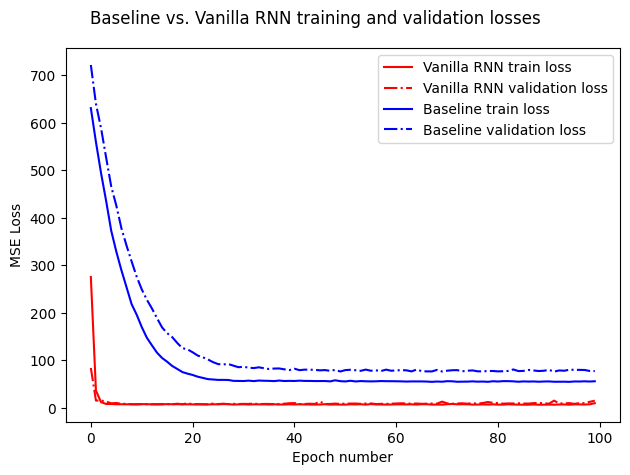

In [30]:
### Visualizations
epochs_xaxis = [i for i in range(epochs)]

fig, ax = plt.subplots()
# ax2 = ax.twinx()
ax.plot(epochs_xaxis, vrnn_train_loss, color = 'r', linestyle = '-', label = "Vanilla RNN train loss")
ax.plot(epochs_xaxis, vrnn_val_loss, color = 'r', linestyle = '-.', label = "Vanilla RNN validation loss")

ax.plot(epochs_xaxis, baseline_train_loss, color = 'b', linestyle = '-', label = "Baseline train loss")
ax.plot(epochs_xaxis, baseline_val_loss, color = 'b', linestyle = '-.', label = "Baseline validation loss")

ax.set_xlabel('Epoch number')
ax.set_ylabel('MSE Loss')
fig.suptitle("Baseline vs. Vanilla RNN training and validation losses")
fig.tight_layout()
fig.legend(bbox_to_anchor=(1, 1), loc="upper right", bbox_transform=ax.transAxes)
plt.show()
# fig.savefig("train-val-losses.png", format="png")

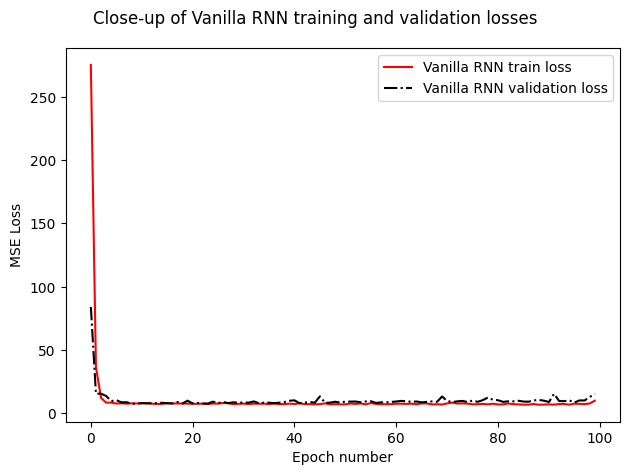

In [35]:
### Close-up Visualizations
plt.plot(epochs_xaxis, vrnn_train_loss, color = 'r', linestyle = '-', label = "Vanilla RNN train loss")
plt.plot(epochs_xaxis, vrnn_val_loss, color = 'k', linestyle = '-.', label = "Vanilla RNN validation loss")
plt.xlabel('Epoch number')
plt.ylabel('MSE Loss')
plt.suptitle("Close-up of Vanilla RNN training and validation losses")
plt.tight_layout()
plt.legend()
plt.show()
# plt.savefig("vanilla-rnn-close-up.png", format="png")

In [32]:
print("Baseline: \ntrain loss: {} \nval. loss: {} \nVanilla RNN: \ntrain loss: {} \nval. loss: {}  ".format(baseline_train_loss[-1],
                baseline_val_loss[-1],
                vrnn_train_loss[-1],
                vrnn_val_loss[-1]))


Baseline: 
train loss: 55.9410275050572 
val. loss: 77.3403205871582 
Vanilla RNN: 
train loss: 9.727148859841483 
val. loss: 14.963695685068766  


In [34]:
### find epoch when validation loss is the lowest
# for baseline
best_baseline_epoch = baseline_val_loss.index(min(baseline_val_loss))

# for vanilla RNN
best_vrnn_epoch = vrnn_val_loss.index(min(vrnn_val_loss))

print("the best epoch for baseline is {} and for vanilla rnn is {}".format(best_baseline_epoch, best_vrnn_epoch))

### Find difference in performance

diff = min(baseline_val_loss) - min(vrnn_val_loss)
print("{:.2f} - {:.2f} = {:.2f}".format(min(baseline_val_loss),  min(vrnn_val_loss), diff))

the best epoch for baseline is 91 and for vanilla rnn is 9
76.22 - 7.29 = 68.93


__Exercise 3.2:__ (4 marks)
* Using relevant visualisations and/or statistical tests, discuss the relative performance of the Baseline model and VanillaRNN model. Conclude whether an RNN architecture should be used for this modelling task (based __only__ on the previously mentioned visualisations or statistical tests). __No marks__ will be awarded for justifications based on the sequential nature of the data.
* Choose an appropriate epoch for each model and report the difference in performance on the validation set. Justify why you chose the epochs you did for each model.

__WRITTEN ANSWER VanillaRNN performance vs baseline__: From the training and validation losses, it is clear that the (vanilla) RNN architecture should be used to model the mean temperature given prior features. Evidently, as shown in the plot, both its training and validation MSE loss decrease exponentially until plateauing at around 10, and this is faster than the baseline. The loss achieved by the baseline model is too high, converging at around 75 for validation (values may vary due to stochasticity). The RNN's validation loss is slightly greater than training loss


__WRITTEN ANSWER best epoch and difference in performance__: The lowest validation loss for the vanilla RNN was around epoch 10, a point which I could have early-stopped. Similarly, an epoch between 80-90 corresponds to the lowest validation loss for the baseline. The difference in validation performance is  $75 - 7 = 68$ (values may differ due to stochasticity)


## Task4: RNN experimentation

It is hypothesised that the VanillaRNN model can be improved.

__Exercise 4.1__: (4 marks)

Devise an experiment to develop another RNN model making a _single_ change to the VanillaRNN model. This change may include (but is not limited to):
* Swapping the linear head to a non-linear MLP;
* Altering hyperparameters such as the learning rate;
* Increasing the depth of the RNN unit etc.

The ```ExtendedRNN``` class below is used later in the code however, you may choose to use it for implementing your experiment here as it allows MLP heads to be easily implemented.

Complete the markdown block below. You experiment hypothesis must:
* Reference clearly the change you will make;
* Reference relavent evidence from the previous model runs as to why you believe implementing this change will _improve_ the performance of the ```VanillaRNN``` model.

__WRITTEN ANSWER experiment hypothesis__:
* __Change to be made:__ I will alter the lookback hyperparameter that the Vanilla RNN sees to make a prediction. I will experiment with lookbacks in [3, 5, 7, 9]. I will keep everything else the same.
* __Justification:__ the VanillaRNN already achieves a low loss by just looking back at 2 timesteps. I hypothesize that with a wider lookback window there is more contextual information to make an informed prediction of the next temperature in 5 days. Intuitively, the more about the past I know, the more accurate the prediction of the future.

In [56]:
class ExtendedRNN(nn.Module):

    def __init__(
        self, input_dim:int,  rnn_hidden_dim:int, rnn_num_layers:int,
        fc_head_layers:List[int], nonlinearity:str
    ) -> None:
        torch.manual_seed(MODEL_SEED)
        super().__init__()
        self._num_layers = num_layers
        self._hidden_dim = hidden_dim
        self.rnn = nn.RNN(
            input_size=input_dim,  hidden_size=hidden_dim,
            num_layers=num_layers, nonlinearity=nonlinearity,
            batch_first=True
        )
        if nonlinearity == "relu":
            self.fc_non_linear = nn.ReLU()
        else:
            self.fc_non_linear = nn.Tanh()
        self.fc = nn.ModuleList()
        fc_head_layers = [hidden_dim, *fc_head_layers]
        for i in range(len(fc_head_layers)-1):
            self.fc.append(nn.Linear(in_features=fc_head_layers[i], out_features=fc_head_layers[i+1]))
            if i != len(fc_head_layers)-1:
                self.fc.append(self.fc_non_linear)

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out = self.rnn(x, hidden)
        out = out[1].squeeze()
        for layer in self.fc:
            out = layer(out)
        if not self.training:
            out = out[:,0][:, None]
        return out


    def init_hidden(self, batch_size):
        hidden = torch.zeros(self._num_layers, batch_size, self._hidden_dim)
        return hidden


__Exercise 4.2__: (3 marks)
* Implement your proposed experiment in the code block below.

_Hint_:
* It is __strongly__ suggested that all elements of the experiment be redefined within the __single__ codeblock below, including (but not limited to): input dimensions, target variable, input datasets and dataloaders. Since object names are reused throughout this jupyter notebook, defining all objects (not classes or functions) within the same codeblock will ensure that object names describe the objects you expect!

In [40]:
# lr

In [41]:
# Your code here
### for plotting
ext_train_losses_beta = []
ext_val_losses_beta = []
###
for lookback_hparam in [3, 5, 7, 9]:
    train_dataset = PandasTsDataset(X=train_df[non_date_vars], y=train_df[trgt_col], lookback=lookback_hparam)
    val_idx = val_df[trgt_col].isna().sum(axis=1) != 1
    val_dataset = PandasTsDataset(X=val_df[val_idx][non_date_vars], y=val_df[val_idx][trgt_col], lookback=lookback_hparam)
    train_loader = DataLoader(dataset=train_dataset, shuffle=shuffle, batch_size=batch_size)
    val_loader = DataLoader(dataset=val_dataset, shuffle=shuffle, batch_size=batch_size)

    wandb_config={
    "lr": lr,
    "lookback": lookback_hparam,
    "hidden_dim": hidden_dim,
    "num_layers": num_layers,
    "nonlinearity": nonlinearity,
    "fc_output_size": fc_output_size
    }
    model = VanillaRNN(
    input_dim=input_dim,  hidden_dim=wandb_config["hidden_dim"],
    num_layers=wandb_config["num_layers"], fc_output_size=wandb_config["fc_output_size"],
    nonlinearity=wandb_config["nonlinearity"]
    )
    first_batch = next(train_loader.__iter__())
    with torch.no_grad():
        print(first_batch[0].shape)
        print(model(first_batch[1]).shape)

    optimizer=torch.optim.Adam(model.parameters(), lr=wandb_config["lr"])
    epoch_train_loss, epoch_val_loss = train(
        model=model, train_data_loader=train_loader, val_data_loader=val_loader, gpu = gpu,
        optimizer=optimizer, criterion=ovrl_criterion, epochs=epochs,
        wandb_proj=WANDB_PROJ, wandb_name="Collab VanillaRNN " + str(lookback_hparam) + " lookback ", wandb_config=wandb_config, debug=False
    )
    ext_train_losses_beta.append(epoch_train_loss)
    ext_val_losses_beta.append(epoch_val_loss)


# Your code here - END

torch.Size([32, 1])
torch.Size([32, 1])


Running training epoch


35it [00:00, 258.68it/s]
12it [00:00, 853.87it/s]


Running validation
Running training epoch


35it [00:00, 256.20it/s]
12it [00:00, 671.33it/s]


Running validation
Running training epoch


35it [00:00, 333.08it/s]
12it [00:00, 881.20it/s]


Running validation
Running training epoch


35it [00:00, 220.45it/s]
12it [00:00, 589.30it/s]


Running validation
Running training epoch


35it [00:00, 258.98it/s]
12it [00:00, 712.49it/s]


Running validation
Running training epoch


35it [00:00, 258.17it/s]
12it [00:00, 514.43it/s]


Running validation
Running training epoch


35it [00:00, 266.09it/s]
12it [00:00, 538.42it/s]


Running validation
Running training epoch


35it [00:00, 413.21it/s]
12it [00:00, 842.70it/s]


Running validation
Running training epoch


35it [00:00, 309.34it/s]
12it [00:00, 812.98it/s]


Running validation
Running training epoch


35it [00:00, 413.21it/s]
12it [00:00, 883.63it/s]


Running validation
Running training epoch


35it [00:00, 384.51it/s]
12it [00:00, 856.50it/s]


Running validation
Running training epoch


35it [00:00, 251.71it/s]
12it [00:00, 690.32it/s]


Running validation
Running training epoch


35it [00:00, 297.00it/s]
12it [00:00, 841.03it/s]


Running validation
Running training epoch


35it [00:00, 399.41it/s]
12it [00:00, 966.02it/s]


Running validation
Running training epoch


35it [00:00, 346.93it/s]
12it [00:00, 846.79it/s]


Running validation
Running training epoch


35it [00:00, 355.21it/s]
12it [00:00, 660.62it/s]


Running validation
Running training epoch


35it [00:00, 374.06it/s]
12it [00:00, 827.65it/s]


Running validation
Running training epoch


35it [00:00, 386.65it/s]
12it [00:00, 761.92it/s]


Running validation
Running training epoch


35it [00:00, 406.38it/s]
12it [00:00, 842.77it/s]


Running validation
Running training epoch


35it [00:00, 395.73it/s]
12it [00:00, 876.86it/s]


Running validation
Running training epoch


35it [00:00, 373.52it/s]
12it [00:00, 784.31it/s]


Running validation
Running training epoch


35it [00:00, 366.71it/s]
12it [00:00, 906.60it/s]


Running validation
Running training epoch


35it [00:00, 373.72it/s]
12it [00:00, 763.91it/s]


Running validation
Running training epoch


35it [00:00, 367.05it/s]
12it [00:00, 813.95it/s]


Running validation
Running training epoch


35it [00:00, 319.50it/s]
12it [00:00, 914.12it/s]


Running validation
Running training epoch


35it [00:00, 366.63it/s]
12it [00:00, 896.71it/s]


Running validation
Running training epoch


35it [00:00, 375.72it/s]
12it [00:00, 717.27it/s]


Running validation
Running training epoch


35it [00:00, 368.50it/s]
12it [00:00, 823.87it/s]


Running validation
Running training epoch


35it [00:00, 350.75it/s]
12it [00:00, 752.44it/s]


Running validation
Running training epoch


35it [00:00, 362.00it/s]
12it [00:00, 827.82it/s]


Running validation
Running training epoch


35it [00:00, 215.18it/s]
12it [00:00, 701.27it/s]


Running validation
Running training epoch


35it [00:00, 254.53it/s]
12it [00:00, 470.28it/s]


Running validation
Running training epoch


35it [00:00, 192.36it/s]
12it [00:00, 476.43it/s]


Running validation
Running training epoch


35it [00:00, 220.67it/s]
12it [00:00, 584.90it/s]


Running validation
Running training epoch


35it [00:00, 233.58it/s]
12it [00:00, 421.13it/s]


Running validation
Running training epoch


35it [00:00, 240.98it/s]
12it [00:00, 679.51it/s]


Running validation
Running training epoch


35it [00:00, 215.95it/s]
12it [00:00, 665.22it/s]


Running validation
Running training epoch


35it [00:00, 247.79it/s]
12it [00:00, 575.65it/s]


Running validation
Running training epoch


35it [00:00, 236.57it/s]
12it [00:00, 682.69it/s]


Running validation
Running training epoch


35it [00:00, 213.83it/s]
12it [00:00, 486.61it/s]


Running validation
Running training epoch


35it [00:00, 229.86it/s]
12it [00:00, 583.17it/s]


Running validation
Running training epoch


35it [00:00, 257.40it/s]
12it [00:00, 511.05it/s]


Running validation
Running training epoch


35it [00:00, 243.41it/s]
12it [00:00, 646.40it/s]


Running validation
Running training epoch


35it [00:00, 260.28it/s]
12it [00:00, 677.74it/s]


Running validation
Running training epoch


35it [00:00, 252.91it/s]
12it [00:00, 591.81it/s]


Running validation
Running training epoch


35it [00:00, 236.59it/s]
12it [00:00, 676.39it/s]


Running validation
Running training epoch


35it [00:00, 251.33it/s]
12it [00:00, 715.89it/s]


Running validation
Running training epoch


35it [00:00, 259.88it/s]
12it [00:00, 716.84it/s]


Running validation
Running training epoch


35it [00:00, 248.85it/s]
12it [00:00, 698.58it/s]


Running validation
Running training epoch


35it [00:00, 272.58it/s]
12it [00:00, 616.20it/s]


Running validation
Running training epoch


35it [00:00, 250.46it/s]
12it [00:00, 577.73it/s]

Running validation
Running training epoch

35it [00:00, 247.01it/s]
12it [00:00, 698.26it/s]


Running validation
Running training epoch


35it [00:00, 247.52it/s]
12it [00:00, 647.56it/s]


Running validation
Running training epoch


35it [00:00, 257.47it/s]
12it [00:00, 660.41it/s]


Running validation
Running training epoch


35it [00:00, 253.30it/s]
12it [00:00, 720.71it/s]


Running validation
Running training epoch


35it [00:00, 251.99it/s]
12it [00:00, 472.91it/s]

Running validation


Running training epoch


35it [00:00, 233.72it/s]
12it [00:00, 644.64it/s]


Running validation
Running training epoch


35it [00:00, 206.70it/s]
12it [00:00, 429.99it/s]


Running validation
Running training epoch


35it [00:00, 218.11it/s]
12it [00:00, 518.87it/s]


Running validation
Running training epoch


35it [00:00, 204.21it/s]
12it [00:00, 647.85it/s]


Running validation
Running training epoch


35it [00:00, 225.10it/s]
12it [00:00, 437.73it/s]


Running validation
Running training epoch


35it [00:00, 204.47it/s]
12it [00:00, 519.56it/s]


Running validation
Running training epoch


35it [00:00, 345.95it/s]
12it [00:00, 853.27it/s]


Running validation
Running training epoch


35it [00:00, 357.58it/s]
12it [00:00, 935.41it/s]


Running validation
Running training epoch


35it [00:00, 355.52it/s]
12it [00:00, 919.95it/s]


Running validation
Running training epoch


35it [00:00, 334.65it/s]
12it [00:00, 786.24it/s]


Running validation
Running training epoch


35it [00:00, 360.32it/s]
12it [00:00, 427.39it/s]


Running validation
Running training epoch


35it [00:00, 375.52it/s]
12it [00:00, 745.10it/s]


Running validation
Running training epoch


35it [00:00, 385.73it/s]
12it [00:00, 864.95it/s]


Running validation
Running training epoch


35it [00:00, 369.15it/s]
12it [00:00, 766.85it/s]


Running validation
Running training epoch


35it [00:00, 290.87it/s]
12it [00:00, 889.79it/s]


Running validation
Running training epoch


35it [00:00, 309.95it/s]
12it [00:00, 836.13it/s]


Running validation
Running training epoch


35it [00:00, 359.08it/s]
12it [00:00, 698.00it/s]


Running validation
Running training epoch


35it [00:00, 356.57it/s]
12it [00:00, 1042.71it/s]


Running validation
Running training epoch


35it [00:00, 318.02it/s]
12it [00:00, 940.48it/s]


Running validation
Running training epoch


35it [00:00, 357.04it/s]
12it [00:00, 700.70it/s]


Running validation
Running training epoch


35it [00:00, 379.99it/s]
12it [00:00, 714.11it/s]


Running validation
Running training epoch


35it [00:00, 399.52it/s]
12it [00:00, 786.89it/s]


Running validation
Running training epoch


35it [00:00, 379.92it/s]
12it [00:00, 771.98it/s]


Running validation
Running training epoch


35it [00:00, 378.02it/s]
12it [00:00, 822.55it/s]


Running validation
Running training epoch


35it [00:00, 360.22it/s]
12it [00:00, 791.99it/s]


Running validation
Running training epoch


35it [00:00, 292.99it/s]
12it [00:00, 786.69it/s]


Running validation
Running training epoch


35it [00:00, 378.47it/s]
12it [00:00, 867.14it/s]


Running validation
Running training epoch


35it [00:00, 378.21it/s]
12it [00:00, 814.19it/s]


Running validation
Running training epoch


35it [00:00, 359.14it/s]
12it [00:00, 766.16it/s]


Running validation
Running training epoch


35it [00:00, 366.05it/s]
12it [00:00, 830.60it/s]


Running validation
Running training epoch


35it [00:00, 299.37it/s]
12it [00:00, 849.88it/s]


Running validation
Running training epoch


35it [00:00, 319.76it/s]
12it [00:00, 998.11it/s]


Running validation
Running training epoch


35it [00:00, 357.94it/s]
12it [00:00, 867.79it/s]


Running validation
Running training epoch


35it [00:00, 360.07it/s]
12it [00:00, 837.40it/s]


Running validation
Running training epoch


35it [00:00, 251.10it/s]
12it [00:00, 551.15it/s]


Running validation
Running training epoch


35it [00:00, 403.03it/s]
12it [00:00, 804.73it/s]


Running validation
Running training epoch


35it [00:00, 373.20it/s]
12it [00:00, 624.44it/s]


Running validation
Running training epoch


35it [00:00, 383.35it/s]
12it [00:00, 760.71it/s]


Running validation
Running training epoch


35it [00:00, 370.41it/s]
12it [00:00, 769.20it/s]


Running validation
Running training epoch


35it [00:00, 317.12it/s]
12it [00:00, 897.63it/s]


Running validation
Running training epoch


35it [00:00, 360.00it/s]
12it [00:00, 723.95it/s]


Running validation
Running training epoch


35it [00:00, 370.80it/s]
12it [00:00, 669.66it/s]


Running validation
Running training epoch


35it [00:00, 384.71it/s]
12it [00:00, 807.54it/s]


Running validation
Running training epoch


35it [00:00, 317.10it/s]
12it [00:00, 475.10it/s]


Running validation


train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▁▂▃▁▁▂▁▄▁▂▂▂▁▂▂█▃▄▂▄▂▄▂▆▃▂▃▃▃▃▅▄▅▃▃▃▅
train_loss,6.32531
val_loss,14.34281


torch.Size([32, 1])
torch.Size([32, 1])


Running training epoch


35it [00:00, 119.42it/s]
12it [00:00, 269.28it/s]


Running validation
Running training epoch


35it [00:00, 175.82it/s]
12it [00:00, 547.00it/s]


Running validation
Running training epoch


35it [00:00, 126.33it/s]
12it [00:00, 404.17it/s]


Running validation
Running training epoch


35it [00:00, 154.32it/s]
12it [00:00, 530.50it/s]


Running validation
Running training epoch


35it [00:00, 206.42it/s]
12it [00:00, 566.09it/s]


Running validation
Running training epoch


35it [00:00, 213.18it/s]
12it [00:00, 683.44it/s]


Running validation
Running training epoch


35it [00:00, 221.13it/s]
12it [00:00, 816.87it/s]


Running validation
Running training epoch


35it [00:00, 300.31it/s]
12it [00:00, 761.90it/s]


Running validation
Running training epoch


35it [00:00, 355.71it/s]
12it [00:00, 663.67it/s]


Running validation
Running training epoch


35it [00:00, 376.81it/s]
12it [00:00, 523.46it/s]


Running validation
Running training epoch


35it [00:00, 295.00it/s]
12it [00:00, 920.17it/s]


Running validation
Running training epoch


35it [00:00, 312.62it/s]
12it [00:00, 846.35it/s]


Running validation
Running training epoch


35it [00:00, 306.97it/s]
12it [00:00, 805.99it/s]


Running validation
Running training epoch


35it [00:00, 319.24it/s]
12it [00:00, 717.00it/s]


Running validation
Running training epoch


35it [00:00, 314.24it/s]
12it [00:00, 910.37it/s]


Running validation
Running training epoch


35it [00:00, 359.43it/s]
12it [00:00, 648.99it/s]


Running validation
Running training epoch


35it [00:00, 316.64it/s]
12it [00:00, 590.48it/s]


Running validation
Running training epoch


35it [00:00, 291.64it/s]
12it [00:00, 788.28it/s]


Running validation
Running training epoch


35it [00:00, 317.70it/s]
12it [00:00, 947.81it/s]


Running validation
Running training epoch


35it [00:00, 315.18it/s]
12it [00:00, 974.17it/s]


Running validation
Running training epoch


35it [00:00, 297.50it/s]
12it [00:00, 646.66it/s]


Running validation
Running training epoch


35it [00:00, 289.59it/s]
12it [00:00, 936.93it/s]


Running validation
Running training epoch


35it [00:00, 298.60it/s]
12it [00:00, 732.93it/s]


Running validation
Running training epoch


35it [00:00, 255.28it/s]
12it [00:00, 740.75it/s]


Running validation
Running training epoch


35it [00:00, 254.84it/s]
12it [00:00, 852.65it/s]


Running validation
Running training epoch


35it [00:00, 292.85it/s]
12it [00:00, 952.51it/s]


Running validation
Running training epoch


35it [00:00, 285.73it/s]
12it [00:00, 791.64it/s]


Running validation
Running training epoch


35it [00:00, 295.90it/s]
12it [00:00, 758.72it/s]


Running validation
Running training epoch


35it [00:00, 330.15it/s]
12it [00:00, 688.96it/s]


Running validation
Running training epoch


35it [00:00, 292.79it/s]
12it [00:00, 855.37it/s]


Running validation
Running training epoch


35it [00:00, 299.17it/s]
12it [00:00, 869.30it/s]


Running validation
Running training epoch


35it [00:00, 309.18it/s]
12it [00:00, 870.32it/s]


Running validation
Running training epoch


35it [00:00, 239.09it/s]
12it [00:00, 720.01it/s]


Running validation
Running training epoch


35it [00:00, 241.02it/s]
12it [00:00, 746.16it/s]


Running validation
Running training epoch


35it [00:00, 333.44it/s]
12it [00:00, 916.95it/s]


Running validation
Running training epoch


35it [00:00, 285.93it/s]
12it [00:00, 809.91it/s]


Running validation
Running training epoch


35it [00:00, 286.02it/s]
12it [00:00, 836.64it/s]


Running validation
Running training epoch


35it [00:00, 366.78it/s]
12it [00:00, 647.55it/s]


Running validation
Running training epoch


35it [00:00, 322.23it/s]
12it [00:00, 664.53it/s]


Running validation
Running training epoch


35it [00:00, 335.61it/s]
12it [00:00, 722.22it/s]


Running validation
Running training epoch


35it [00:00, 309.19it/s]
12it [00:00, 698.20it/s]


Running validation
Running training epoch


35it [00:00, 304.82it/s]
12it [00:00, 612.37it/s]


Running validation
Running training epoch


35it [00:00, 292.79it/s]
12it [00:00, 783.07it/s]


Running validation
Running training epoch


35it [00:00, 317.33it/s]
12it [00:00, 779.78it/s]


Running validation
Running training epoch


35it [00:00, 333.47it/s]
12it [00:00, 764.42it/s]


Running validation
Running training epoch


35it [00:00, 307.20it/s]
12it [00:00, 632.73it/s]


Running validation
Running training epoch


35it [00:00, 312.03it/s]
12it [00:00, 864.46it/s]


Running validation
Running training epoch


35it [00:00, 253.20it/s]
12it [00:00, 911.82it/s]


Running validation
Running training epoch


35it [00:00, 264.35it/s]
12it [00:00, 703.10it/s]


Running validation
Running training epoch


35it [00:00, 324.83it/s]
12it [00:00, 819.27it/s]


Running validation
Running training epoch


35it [00:00, 311.29it/s]
12it [00:00, 551.01it/s]


Running validation
Running training epoch


35it [00:00, 316.17it/s]
12it [00:00, 738.20it/s]


Running validation
Running training epoch


35it [00:00, 314.47it/s]
12it [00:00, 786.27it/s]


Running validation
Running training epoch


35it [00:00, 292.92it/s]
12it [00:00, 808.14it/s]


Running validation
Running training epoch


35it [00:00, 320.73it/s]
12it [00:00, 671.81it/s]


Running validation
Running training epoch


35it [00:00, 220.85it/s]
12it [00:00, 934.61it/s]


Running validation
Running training epoch


35it [00:00, 278.18it/s]
12it [00:00, 828.64it/s]


Running validation
Running training epoch


35it [00:00, 274.50it/s]
12it [00:00, 730.28it/s]


Running validation
Running training epoch


35it [00:00, 294.64it/s]
12it [00:00, 713.80it/s]


Running validation
Running training epoch


35it [00:00, 269.11it/s]
12it [00:00, 894.91it/s]


Running validation
Running training epoch


35it [00:00, 276.00it/s]
12it [00:00, 699.61it/s]


Running validation
Running training epoch


35it [00:00, 348.19it/s]
12it [00:00, 670.40it/s]


Running validation
Running training epoch


35it [00:00, 331.84it/s]
12it [00:00, 722.56it/s]


Running validation
Running training epoch


35it [00:00, 300.77it/s]
12it [00:00, 963.06it/s]


Running validation
Running training epoch


35it [00:00, 291.83it/s]
12it [00:00, 935.86it/s]


Running validation
Running training epoch


35it [00:00, 293.68it/s]
12it [00:00, 857.06it/s]


Running validation
Running training epoch


35it [00:00, 293.96it/s]
12it [00:00, 404.85it/s]


Running validation
Running training epoch


35it [00:00, 219.06it/s]
12it [00:00, 574.53it/s]


Running validation
Running training epoch


35it [00:00, 208.79it/s]
12it [00:00, 610.84it/s]


Running validation
Running training epoch


35it [00:00, 228.76it/s]
12it [00:00, 546.12it/s]


Running validation
Running training epoch


35it [00:00, 247.37it/s]
12it [00:00, 640.00it/s]


Running validation
Running training epoch


35it [00:00, 222.09it/s]
12it [00:00, 421.97it/s]


Running validation
Running training epoch


35it [00:00, 247.63it/s]
12it [00:00, 507.95it/s]


Running validation
Running training epoch


35it [00:00, 217.38it/s]
12it [00:00, 476.16it/s]


Running validation
Running training epoch


35it [00:00, 220.81it/s]
12it [00:00, 564.53it/s]


Running validation
Running training epoch


35it [00:00, 227.27it/s]
12it [00:00, 541.65it/s]


Running validation
Running training epoch


35it [00:00, 208.74it/s]
12it [00:00, 626.87it/s]


Running validation
Running training epoch


35it [00:00, 193.62it/s]
12it [00:00, 533.68it/s]


Running validation
Running training epoch


35it [00:00, 217.55it/s]
12it [00:00, 622.52it/s]


Running validation
Running training epoch


35it [00:00, 200.65it/s]
12it [00:00, 613.06it/s]


Running validation
Running training epoch


35it [00:00, 232.17it/s]
12it [00:00, 480.56it/s]


Running validation
Running training epoch


35it [00:00, 187.59it/s]
12it [00:00, 574.54it/s]


Running validation
Running training epoch


35it [00:00, 237.18it/s]
12it [00:00, 591.56it/s]


Running validation
Running training epoch


35it [00:00, 212.43it/s]
12it [00:00, 414.46it/s]


Running validation
Running training epoch


35it [00:00, 211.84it/s]
12it [00:00, 651.42it/s]


Running validation
Running training epoch


35it [00:00, 216.31it/s]
12it [00:00, 658.98it/s]


Running validation
Running training epoch


35it [00:00, 158.12it/s]
12it [00:00, 540.09it/s]


Running validation
Running training epoch


35it [00:00, 219.23it/s]
12it [00:00, 460.28it/s]


Running validation
Running training epoch


35it [00:00, 197.49it/s]
12it [00:00, 628.89it/s]


Running validation
Running training epoch


35it [00:00, 198.25it/s]
12it [00:00, 672.15it/s]


Running validation
Running training epoch


35it [00:00, 206.00it/s]
12it [00:00, 574.92it/s]


Running validation
Running training epoch


35it [00:00, 205.01it/s]
12it [00:00, 615.70it/s]


Running validation
Running training epoch


35it [00:00, 179.20it/s]
12it [00:00, 554.86it/s]


Running validation
Running training epoch


35it [00:00, 196.37it/s]
12it [00:00, 537.46it/s]


Running validation
Running training epoch


35it [00:00, 185.28it/s]
12it [00:00, 541.49it/s]


Running validation
Running training epoch


35it [00:00, 200.17it/s]
12it [00:00, 615.41it/s]


Running validation
Running training epoch


35it [00:00, 207.98it/s]
12it [00:00, 528.02it/s]


Running validation
Running training epoch


35it [00:00, 218.19it/s]
12it [00:00, 702.08it/s]


Running validation
Running training epoch


35it [00:00, 268.69it/s]
12it [00:00, 810.82it/s]


Running validation
Running training epoch


35it [00:00, 275.10it/s]
12it [00:00, 834.74it/s]


Running validation


train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▂▃▁▁▃▁▁▁▂▁▂▁▄▂▅▄▂▁▂▄▂▂▁▁▂▁▂█▁▁▂▂▂▂▁▂▂▄▂
train_loss,7.17182
val_loss,12.15192


torch.Size([32, 1])
torch.Size([32, 1])


Running training epoch


24it [00:00, 231.38it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
35it [00:00, 217.62it/s]
12it [00:00, 634.86it/s]

Running validation


Running training epoch


35it [00:00, 207.44it/s]
12it [00:00, 647.45it/s]


Running validation
Running training epoch


35it [00:00, 266.54it/s]
12it [00:00, 453.82it/s]


Running validation
Running training epoch


35it [00:00, 187.75it/s]
12it [00:00, 641.32it/s]


Running validation
Running training epoch


35it [00:00, 244.77it/s]
12it [00:00, 858.92it/s]


Running validation
Running training epoch


35it [00:00, 297.64it/s]
12it [00:00, 542.02it/s]


Running validation
Running training epoch


35it [00:00, 201.63it/s]
12it [00:00, 452.54it/s]


Running validation
Running training epoch


35it [00:00, 198.39it/s]
12it [00:00, 654.70it/s]


Running validation
Running training epoch


35it [00:00, 220.27it/s]
12it [00:00, 611.70it/s]


Running validation
Running training epoch


35it [00:00, 121.91it/s]
12it [00:00, 390.96it/s]


Running validation
Running training epoch


35it [00:00, 194.92it/s]
12it [00:00, 613.40it/s]


Running validation
Running training epoch


35it [00:00, 198.39it/s]
12it [00:00, 599.16it/s]


Running validation
Running training epoch


35it [00:00, 217.35it/s]
12it [00:00, 578.80it/s]


Running validation
Running training epoch


35it [00:00, 213.19it/s]
12it [00:00, 608.00it/s]


Running validation
Running training epoch


35it [00:00, 208.77it/s]
12it [00:00, 606.92it/s]


Running validation
Running training epoch


35it [00:00, 212.21it/s]
12it [00:00, 373.68it/s]


Running validation
Running training epoch


35it [00:00, 167.56it/s]
12it [00:00, 515.37it/s]


Running validation
Running training epoch


35it [00:00, 185.61it/s]
12it [00:00, 544.74it/s]


Running validation
Running training epoch


35it [00:00, 206.07it/s]
12it [00:00, 586.73it/s]


Running validation
Running training epoch


35it [00:00, 214.45it/s]
12it [00:00, 629.37it/s]


Running validation
Running training epoch


35it [00:00, 156.19it/s]
12it [00:00, 592.95it/s]


Running validation
Running training epoch


35it [00:00, 204.74it/s]
12it [00:00, 575.42it/s]


Running validation
Running training epoch


35it [00:00, 187.40it/s]
12it [00:00, 612.20it/s]


Running validation
Running training epoch


35it [00:00, 200.66it/s]
12it [00:00, 607.26it/s]


Running validation
Running training epoch


35it [00:00, 192.81it/s]
12it [00:00, 515.27it/s]


Running validation
Running training epoch


35it [00:00, 209.98it/s]
12it [00:00, 581.74it/s]


Running validation
Running training epoch


35it [00:00, 209.03it/s]
12it [00:00, 476.58it/s]


Running validation
Running training epoch


35it [00:00, 179.70it/s]
12it [00:00, 601.18it/s]


Running validation
Running training epoch


35it [00:00, 192.75it/s]
12it [00:00, 520.36it/s]


Running validation
Running training epoch


35it [00:00, 186.70it/s]
12it [00:00, 464.92it/s]


Running validation
Running training epoch


35it [00:00, 195.53it/s]
12it [00:00, 521.24it/s]


Running validation
Running training epoch


35it [00:00, 172.65it/s]
12it [00:00, 500.65it/s]


Running validation
Running training epoch


35it [00:00, 189.81it/s]
12it [00:00, 524.18it/s]


Running validation
Running training epoch


35it [00:00, 175.72it/s]
12it [00:00, 494.11it/s]


Running validation
Running training epoch


35it [00:00, 162.10it/s]
12it [00:00, 478.65it/s]


Running validation
Running training epoch


35it [00:00, 183.39it/s]
12it [00:00, 528.83it/s]


Running validation
Running training epoch


35it [00:00, 281.16it/s]
12it [00:00, 622.07it/s]


Running validation
Running training epoch


35it [00:00, 282.59it/s]
12it [00:00, 621.54it/s]


Running validation
Running training epoch


35it [00:00, 257.93it/s]
12it [00:00, 844.53it/s]


Running validation
Running training epoch


35it [00:00, 268.13it/s]
12it [00:00, 871.29it/s]


Running validation
Running training epoch


35it [00:00, 287.34it/s]
12it [00:00, 655.76it/s]


Running validation
Running training epoch


35it [00:00, 262.67it/s]
12it [00:00, 784.83it/s]


Running validation
Running training epoch


35it [00:00, 287.91it/s]
12it [00:00, 748.99it/s]


Running validation
Running training epoch


35it [00:00, 265.70it/s]
12it [00:00, 550.37it/s]


Running validation
Running training epoch


35it [00:00, 286.61it/s]
12it [00:00, 669.14it/s]


Running validation
Running training epoch


35it [00:00, 288.03it/s]
12it [00:00, 816.13it/s]


Running validation
Running training epoch


35it [00:00, 265.81it/s]
12it [00:00, 714.41it/s]


Running validation
Running training epoch


35it [00:00, 280.40it/s]
12it [00:00, 712.91it/s]


Running validation
Running training epoch


35it [00:00, 265.90it/s]
12it [00:00, 746.37it/s]


Running validation
Running training epoch


35it [00:00, 274.44it/s]
12it [00:00, 668.91it/s]


Running validation
Running training epoch


35it [00:00, 280.84it/s]
12it [00:00, 681.16it/s]


Running validation
Running training epoch


35it [00:00, 257.79it/s]
12it [00:00, 527.39it/s]


Running validation
Running training epoch


35it [00:00, 302.18it/s]
12it [00:00, 674.18it/s]


Running validation
Running training epoch


35it [00:00, 263.93it/s]
12it [00:00, 755.81it/s]


Running validation
Running training epoch


35it [00:00, 260.62it/s]
12it [00:00, 624.19it/s]


Running validation
Running training epoch


35it [00:00, 293.66it/s]
12it [00:00, 161.26it/s]


Running validation
Running training epoch


35it [00:00, 137.25it/s]
12it [00:00, 448.10it/s]


Running validation
Running training epoch


35it [00:00, 119.04it/s]
12it [00:00, 557.98it/s]


Running validation
Running training epoch


35it [00:00, 78.98it/s]
12it [00:00, 166.57it/s]


Running validation
Running training epoch


35it [00:00, 149.70it/s]
12it [00:00, 439.41it/s]


Running validation
Running training epoch


35it [00:00, 108.47it/s]
12it [00:00, 761.72it/s]


Running validation
Running training epoch


35it [00:00, 267.71it/s]
12it [00:00, 725.83it/s]


Running validation
Running training epoch


35it [00:00, 90.41it/s]
12it [00:00, 208.36it/s]


Running validation
Running training epoch


35it [00:00, 61.64it/s]
12it [00:00, 360.81it/s]


Running validation
Running training epoch


35it [00:00, 92.00it/s]
12it [00:00, 268.30it/s]


Running validation
Running training epoch


35it [00:00, 67.92it/s]
12it [00:00, 408.51it/s]


Running validation
Running training epoch


35it [00:00, 53.66it/s]
12it [00:00, 145.85it/s]


Running validation
Running training epoch


35it [00:00, 52.05it/s]
12it [00:00, 311.97it/s]


Running validation
Running training epoch


35it [00:00, 153.78it/s]
12it [00:00, 486.70it/s]


Running validation
Running training epoch


35it [00:00, 69.05it/s]
12it [00:00, 226.65it/s]


Running validation
Running training epoch


35it [00:00, 60.44it/s]
12it [00:00, 225.31it/s]


Running validation
Running training epoch


35it [00:00, 58.08it/s]
12it [00:00, 87.36it/s]


Running validation
Running training epoch


35it [00:01, 33.70it/s]
12it [00:00, 77.75it/s]


Running validation
Running training epoch


35it [00:01, 34.37it/s]
12it [00:00, 188.58it/s]


Running validation
Running training epoch


35it [00:00, 72.91it/s]
12it [00:00, 178.24it/s]


Running validation
Running training epoch


35it [00:00, 91.83it/s]
12it [00:00, 153.34it/s]


Running validation
Running training epoch


35it [00:00, 81.16it/s]
12it [00:00, 206.25it/s]


Running validation
Running training epoch


35it [00:00, 65.81it/s]
12it [00:00, 204.41it/s]


Running validation
Running training epoch


35it [00:00, 92.59it/s]
12it [00:00, 609.11it/s]


Running validation
Running training epoch


35it [00:00, 175.29it/s]
12it [00:00, 212.00it/s]


Running validation
Running training epoch


35it [00:00, 110.18it/s]
12it [00:00, 209.31it/s]


Running validation
Running training epoch


35it [00:00, 188.49it/s]
12it [00:00, 773.77it/s]


Running validation
Running training epoch


35it [00:00, 300.05it/s]
12it [00:00, 740.68it/s]


Running validation
Running training epoch


35it [00:00, 269.67it/s]
12it [00:00, 803.42it/s]


Running validation
Running training epoch


35it [00:00, 262.74it/s]
12it [00:00, 900.31it/s]


Running validation
Running training epoch


35it [00:00, 230.60it/s]
12it [00:00, 603.59it/s]


Running validation
Running training epoch


35it [00:00, 243.05it/s]
12it [00:00, 885.68it/s]


Running validation
Running training epoch


35it [00:00, 280.08it/s]
12it [00:00, 769.96it/s]


Running validation
Running training epoch


35it [00:00, 288.36it/s]
12it [00:00, 562.83it/s]


Running validation
Running training epoch


35it [00:00, 291.21it/s]
12it [00:00, 847.19it/s]


Running validation
Running training epoch


35it [00:00, 262.02it/s]
12it [00:00, 504.93it/s]


Running validation
Running training epoch


35it [00:00, 253.55it/s]
12it [00:00, 830.69it/s]


Running validation
Running training epoch


35it [00:00, 225.50it/s]
12it [00:00, 776.75it/s]


Running validation
Running training epoch


35it [00:00, 290.92it/s]
12it [00:00, 698.04it/s]


Running validation
Running training epoch


35it [00:00, 260.60it/s]
12it [00:00, 831.67it/s]


Running validation
Running training epoch


35it [00:00, 263.31it/s]
12it [00:00, 690.92it/s]


Running validation
Running training epoch


35it [00:00, 263.20it/s]
12it [00:00, 824.11it/s]


Running validation
Running training epoch


35it [00:00, 270.57it/s]
12it [00:00, 542.63it/s]


Running validation
Running training epoch


35it [00:00, 273.60it/s]
12it [00:00, 677.83it/s]


Running validation
Running training epoch


35it [00:00, 288.35it/s]
12it [00:00, 653.58it/s]


Running validation


train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▂▁█▂▂█▁▂▂▃▃▂▅▁▆▁▂▁▁▂▂▆▁▁▃▁▁▁▁█▃▁▁▃▃▁▃▄▁
train_loss,6.97872
val_loss,6.91945


torch.Size([32, 1])
torch.Size([32, 1])


Running training epoch


34it [00:00, 178.99it/s]
12it [00:00, 379.40it/s]


Running validation
Running training epoch


34it [00:00, 195.54it/s]
12it [00:00, 877.24it/s]


Running validation
Running training epoch


34it [00:00, 177.02it/s]
12it [00:00, 615.05it/s]


Running validation
Running training epoch


34it [00:00, 153.82it/s]
12it [00:00, 295.74it/s]


Running validation
Running training epoch


34it [00:00, 212.44it/s]
12it [00:00, 691.00it/s]


Running validation
Running training epoch


34it [00:00, 246.80it/s]
12it [00:00, 752.61it/s]


Running validation
Running training epoch


34it [00:00, 257.04it/s]
12it [00:00, 451.70it/s]


Running validation
Running training epoch


34it [00:00, 236.93it/s]
12it [00:00, 550.37it/s]

Running validation


Running training epoch


34it [00:00, 137.48it/s]
12it [00:00, 414.45it/s]


Running validation
Running training epoch


34it [00:00, 233.73it/s]
12it [00:00, 754.60it/s]


Running validation
Running training epoch


34it [00:00, 250.07it/s]
12it [00:00, 637.86it/s]


Running validation
Running training epoch


34it [00:00, 172.77it/s]
12it [00:00, 430.81it/s]


Running validation
Running training epoch


34it [00:00, 228.25it/s]
12it [00:00, 591.51it/s]


Running validation
Running training epoch


34it [00:00, 116.50it/s]
12it [00:00, 544.21it/s]


Running validation
Running training epoch


34it [00:00, 98.95it/s] 
12it [00:00, 289.61it/s]


Running validation
Running training epoch


34it [00:00, 135.63it/s]
12it [00:00, 345.65it/s]


Running validation
Running training epoch


34it [00:00, 143.84it/s]
12it [00:00, 735.85it/s]


Running validation
Running training epoch


34it [00:00, 256.37it/s]
12it [00:00, 333.68it/s]


Running validation
Running training epoch


34it [00:00, 128.68it/s]
12it [00:00, 877.50it/s]


Running validation
Running training epoch


34it [00:00, 248.50it/s]
12it [00:00, 386.22it/s]


Running validation
Running training epoch


34it [00:00, 136.96it/s]
12it [00:00, 361.75it/s]


Running validation
Running training epoch


34it [00:00, 134.27it/s]
12it [00:00, 203.41it/s]


Running validation
Running training epoch


34it [00:00, 129.15it/s]
12it [00:00, 163.17it/s]


Running validation
Running training epoch


34it [00:00, 169.43it/s]
12it [00:00, 765.64it/s]


Running validation
Running training epoch


34it [00:00, 113.12it/s]
12it [00:00, 827.63it/s]


Running validation
Running training epoch


34it [00:00, 251.61it/s]
12it [00:00, 465.01it/s]


Running validation
Running training epoch


34it [00:00, 212.50it/s]
12it [00:00, 536.45it/s]


Running validation
Running training epoch


34it [00:00, 150.83it/s]
12it [00:00, 315.73it/s]


Running validation
Running training epoch


34it [00:00, 112.30it/s]
12it [00:00, 385.63it/s]


Running validation
Running training epoch


34it [00:00, 143.72it/s]
12it [00:00, 314.57it/s]


Running validation
Running training epoch


34it [00:00, 93.37it/s]
12it [00:00, 143.26it/s]


Running validation
Running training epoch


34it [00:00, 91.54it/s]
12it [00:00, 192.60it/s]


Running validation
Running training epoch


34it [00:00, 77.63it/s]
12it [00:00, 222.99it/s]


Running validation
Running training epoch


34it [00:00, 81.55it/s]
12it [00:00, 531.20it/s]


Running validation
Running training epoch


34it [00:00, 81.34it/s]
12it [00:00, 224.92it/s]


Running validation
Running training epoch


34it [00:00, 91.94it/s] 
12it [00:00, 254.11it/s]


Running validation
Running training epoch


34it [00:00, 111.17it/s]
12it [00:00, 298.52it/s]


Running validation
Running training epoch


34it [00:00, 85.72it/s]
12it [00:00, 219.03it/s]


Running validation
Running training epoch


34it [00:00, 75.96it/s]
12it [00:00, 197.16it/s]


Running validation
Running training epoch


34it [00:00, 79.12it/s]
12it [00:00, 269.28it/s]


Running validation
Running training epoch


34it [00:00, 75.08it/s]
12it [00:00, 228.61it/s]


Running validation
Running training epoch


34it [00:00, 160.90it/s]
12it [00:00, 510.74it/s]


Running validation
Running training epoch


34it [00:00, 163.07it/s]
12it [00:00, 479.91it/s]


Running validation
Running training epoch


34it [00:00, 145.02it/s]
12it [00:00, 378.40it/s]


Running validation
Running training epoch


34it [00:00, 150.75it/s]
12it [00:00, 551.13it/s]


Running validation
Running training epoch


34it [00:00, 160.34it/s]
12it [00:00, 485.89it/s]


Running validation
Running training epoch


34it [00:00, 160.83it/s]
12it [00:00, 440.53it/s]


Running validation
Running training epoch


34it [00:00, 127.28it/s]
12it [00:00, 326.71it/s]


Running validation
Running training epoch


34it [00:00, 155.56it/s]
12it [00:00, 288.33it/s]


Running validation
Running training epoch


34it [00:00, 153.04it/s]
12it [00:00, 273.04it/s]


Running validation
Running training epoch


34it [00:00, 144.94it/s]
12it [00:00, 266.57it/s]


Running validation
Running training epoch


34it [00:00, 114.98it/s]
12it [00:00, 340.78it/s]


Running validation
Running training epoch


34it [00:00, 104.02it/s]
12it [00:00, 568.60it/s]


Running validation
Running training epoch


34it [00:00, 145.20it/s]
12it [00:00, 546.16it/s]


Running validation
Running training epoch


34it [00:00, 176.73it/s]
12it [00:00, 664.31it/s]


Running validation
Running training epoch


34it [00:00, 183.49it/s]
12it [00:00, 804.52it/s]


Running validation
Running training epoch


34it [00:00, 232.21it/s]
12it [00:00, 613.22it/s]


Running validation
Running training epoch


34it [00:00, 189.09it/s]
12it [00:00, 643.41it/s]


Running validation
Running training epoch


34it [00:00, 175.80it/s]
12it [00:00, 313.45it/s]


Running validation
Running training epoch


34it [00:00, 200.81it/s]
12it [00:00, 680.05it/s]


Running validation
Running training epoch


34it [00:00, 149.73it/s]
12it [00:00, 726.51it/s]


Running validation
Running training epoch


34it [00:00, 228.34it/s]
12it [00:00, 271.53it/s]


Running validation
Running training epoch


34it [00:00, 155.17it/s]
12it [00:00, 698.07it/s]


Running validation
Running training epoch


34it [00:00, 224.78it/s]
12it [00:00, 397.62it/s]


Running validation
Running training epoch


34it [00:00, 185.28it/s]
12it [00:00, 696.93it/s]


Running validation
Running training epoch


34it [00:00, 175.42it/s]
12it [00:00, 442.09it/s]


Running validation
Running training epoch


34it [00:00, 137.98it/s]
12it [00:00, 742.35it/s]


Running validation
Running training epoch


34it [00:00, 166.10it/s]
12it [00:00, 384.72it/s]


Running validation
Running training epoch


34it [00:00, 237.65it/s]
12it [00:00, 555.71it/s]


Running validation
Running training epoch


34it [00:00, 143.15it/s]
12it [00:00, 169.01it/s]


Running validation
Running training epoch


34it [00:00, 183.61it/s]
12it [00:00, 594.12it/s]


Running validation
Running training epoch


34it [00:00, 193.59it/s]
12it [00:00, 221.23it/s]


Running validation
Running training epoch


34it [00:00, 217.62it/s]
12it [00:00, 673.17it/s]


Running validation
Running training epoch


34it [00:00, 186.29it/s]
12it [00:00, 363.38it/s]


Running validation
Running training epoch


34it [00:00, 58.69it/s]
12it [00:00, 146.28it/s]


Running validation
Running training epoch


34it [00:00, 144.02it/s]
12it [00:00, 488.11it/s]


Running validation
Running training epoch


34it [00:00, 199.28it/s]
12it [00:00, 758.48it/s]


Running validation
Running training epoch


34it [00:00, 188.95it/s]
12it [00:00, 592.05it/s]


Running validation
Running training epoch


34it [00:00, 225.20it/s]
12it [00:00, 505.90it/s]


Running validation
Running training epoch


34it [00:00, 154.91it/s]
12it [00:00, 545.06it/s]


Running validation
Running training epoch


34it [00:00, 93.91it/s] 
12it [00:00, 572.84it/s]


Running validation
Running training epoch


34it [00:00, 142.46it/s]
12it [00:00, 163.97it/s]


Running validation
Running training epoch


34it [00:00, 61.12it/s]
12it [00:00, 93.55it/s]


Running validation
Running training epoch


34it [00:00, 43.77it/s]
12it [00:00, 320.73it/s]


Running validation
Running training epoch


34it [00:00, 76.32it/s]
12it [00:00, 122.44it/s]


Running validation
Running training epoch


34it [00:00, 145.35it/s]
12it [00:00, 321.48it/s]


Running validation
Running training epoch


34it [00:00, 74.72it/s]
12it [00:00, 197.32it/s]


Running validation
Running training epoch


34it [00:00, 117.27it/s]
12it [00:00, 358.34it/s]


Running validation
Running training epoch


34it [00:00, 102.60it/s]
12it [00:00, 585.72it/s]


Running validation
Running training epoch


34it [00:00, 88.14it/s]
12it [00:00, 145.19it/s]


Running validation
Running training epoch


34it [00:00, 147.37it/s]
12it [00:00, 368.75it/s]


Running validation
Running training epoch


34it [00:00, 113.94it/s]
12it [00:00, 601.05it/s]


Running validation
Running training epoch


34it [00:00, 107.21it/s]
12it [00:00, 411.03it/s]


Running validation
Running training epoch


34it [00:00, 109.67it/s]
12it [00:00, 344.06it/s]


Running validation
Running training epoch


34it [00:00, 70.09it/s]
12it [00:00, 258.71it/s]


Running validation
Running training epoch


34it [00:00, 64.92it/s]
12it [00:00, 199.83it/s]


Running validation
Running training epoch


34it [00:00, 57.12it/s]
12it [00:00, 168.03it/s]


Running validation
Running training epoch


34it [00:00, 53.91it/s]
12it [00:00, 239.52it/s]


Running validation
Running training epoch


34it [00:00, 125.41it/s]
12it [00:00, 263.89it/s]


Running validation
Running training epoch


34it [00:00, 136.69it/s]
12it [00:00, 202.92it/s]


Running validation


train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▂▁▁▃▁▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,6.47917
val_loss,12.54038


In [44]:
for look_num, val_losses in zip([3, 5, 7, 9], ext_val_losses_beta):
    print("lookback", look_num)
    print("minimum validation loss", min(val_losses))
    print("at epoch: ", val_losses.index(min(val_losses)))
    print("final validations loss", val_losses[-1])
    print("\n")

lookback 3
minimum validation loss 7.358246743679047
at epoch:  21
final validations loss 14.342809120814005


lookback 5
minimum validation loss 7.580553650856018
at epoch:  16
final validations loss 12.151917417844137


lookback 7
minimum validation loss 6.576667606830597
at epoch:  74
final validations loss 6.91944807767868


lookback 9
minimum validation loss 6.1341959436734514
at epoch:  80
final validations loss 12.54037857055664




[]

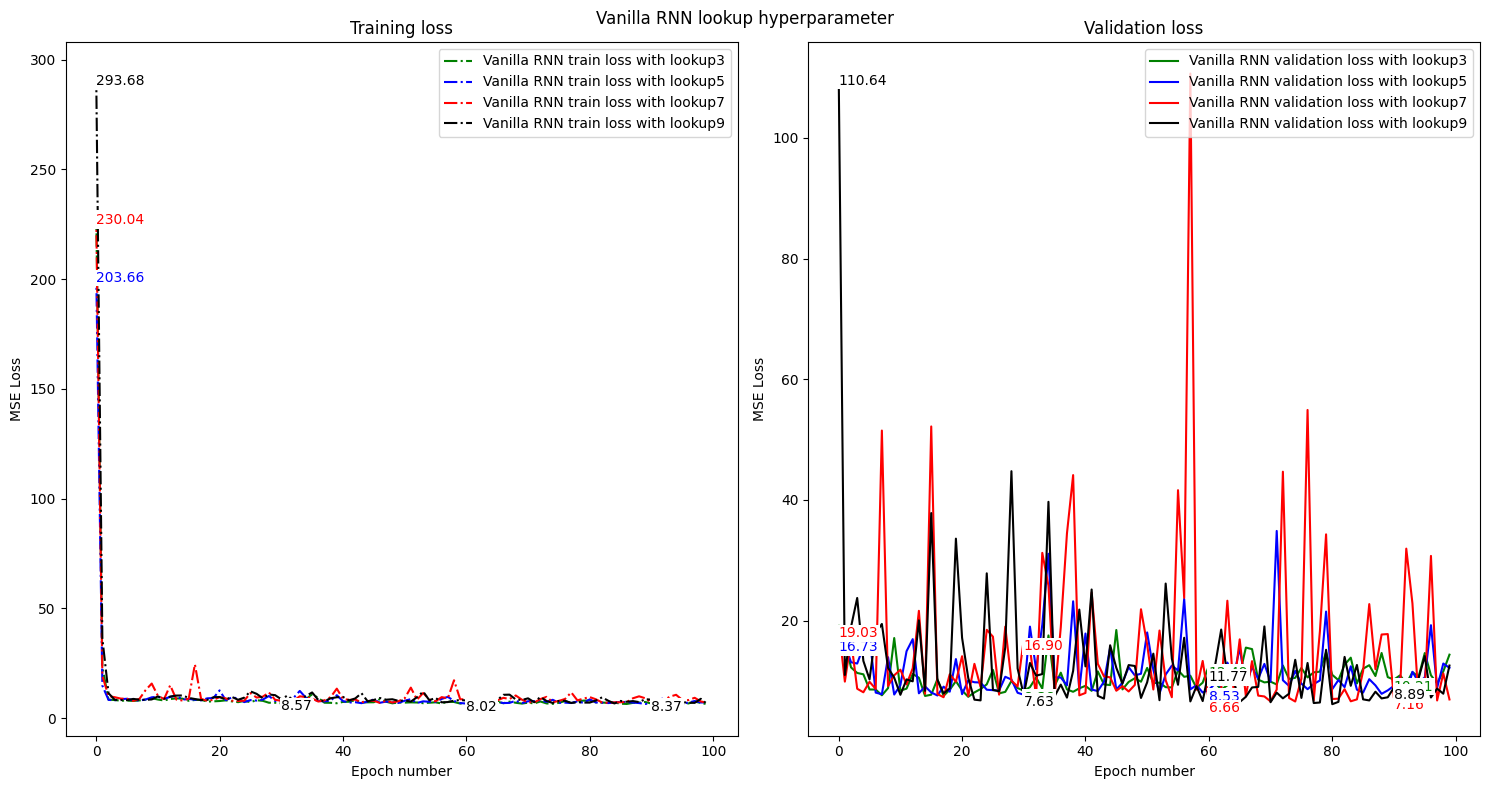

In [43]:
epochs_xaxis = [i for i in range(epochs)]
annotations = True
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

colors = ['g', 'b', 'r', 'k']
col_idx = 0
for look_num, train_losses in zip([3, 5, 7, 9], ext_train_losses_beta):
    ax1.plot(epochs_xaxis, train_losses, linestyle = '-.', label = "Vanilla RNN train loss with lookup" + str(look_num), color = colors[col_idx])
    col_idx += 1

col_idx = 0
for look_num, val_losses in zip([3, 5, 7, 9], ext_val_losses_beta):
    ax2.plot(epochs_xaxis, val_losses, linestyle = '-', label = "Vanilla RNN validation loss with lookup" + str(look_num), color = colors[col_idx])
    col_idx += 1

# annotations may be too crowded. Set to false if too many numbers

if annotations:
  for i in range(len(ext_train_losses_beta)):
      for j in range(0, epochs, 30):
          loss = ext_train_losses_beta[i][j]
          ax1.text(j ,loss , f'{loss:.2f}', va='top', color=colors[i], bbox=dict(facecolor='white', edgecolor='none', pad=1))

  for i in range(len(ext_val_losses_beta)):
      for j in range(0, epochs, 30):
          loss = ext_val_losses_beta[i][j]
          ax2.text(j ,loss , f'{loss:.2f}', va='top', color=colors[i], bbox=dict(facecolor='white', edgecolor='none', pad=1))

ax1.set_xlabel('Epoch number')
ax1.set_ylabel('MSE Loss')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('MSE Loss')
fig.suptitle("Vanilla RNN lookup hyperparameter")
fig.tight_layout()
ax1.set_title("Training loss")
ax2.set_title("Validation loss")
ax1.legend()
ax2.legend()
plt.plot()
# fig.savefig("vanilla-lookup-hparam-annotated.png", format="png")

__Exercise 4.3__: (2 marks)
* Comment on whether your hypothesis was correct given the results and why (we expect to see evidence!)?
* Furthermore, to what extent did your experiment improve performance over the ```VanillaRNN``` model? Evidence must be referenced in your answer.

__WRITTEN ANSWER Experiment conclusion__: After experimenting, my hypothesis was right. Increasing the size of the lookback yields a slight improvement in validation loss of the vanilla RNN. There is a consistent 2-6 points improvement over the VanillaRNN with lookback 2. In particular, lookbacks of 7 and 9 were able to achieve best validation losses below 7, with a lookback of 9 achieving the lowest at around 6 (values may hover due to stochasticity). However, both lookbacks 7 and 9 may overfit as shown in the increases in validation loss in the graphs (red and black lines), so I should have early stopped. All results are shown in the graph.

As mentioned previously, this is because there is more temporal information available, which is useful for predicting the temperature 5 timesteps ahead. However there is some risk of memorization.  

## Task5: Auxiliary loss
Including auxiliary loss functions is a common approach for improving the performance of machine learning models as they increase the amount of gradient signal available for updating parameters. When using an auxiliary loss, it is __critical__ to only use the non-auxiliary loss signal when comparing model performance on the overall project objective. The auxiliary losses that will be used in this coursework are:
* Prediction of 5 step values of mean pressure, humidity and windspeed, herein referred to as __aug-aux-loss__ and;
* Prediction of 1 step values of mean temperature, for each time point in the look back, herein referred to as __inter-aux-loss__;

__Exercise 5.1__: (3 marks)
* The PandasTsDataset and ExtendedRNN class are already able to define a model that uses the __aug-aux-loss__. In the code block below define and run an experiment which implements the following:
    * An RNN with hidden dimension 64;
    * An MLP with a single hidden layer of dimension 32 and relu non-linear activation functions;
    * __aug-aux-loss__ auxiliary loss function

All other hyperparameters should be identical to those defined for the ```VanillaRNN``` model.

_Hint_:
* As in exercise 4.2, it is strongly recommended that you define all required objects for the experiment in a single code block.
* Don't worry if this model doesn't perform well!

In [49]:
wandb_name="aug-aux-rnn"
# Your code here
class AuxExtendedRNN(nn.Module):
    '''
    modfify the forward method of the extended RNN
    slightly to avoid a bug concerning batch dimension
    '''
    def __init__(
        self, input_dim:int,  rnn_hidden_dim:int, rnn_num_layers:int,
        fc_head_layers:List[int], nonlinearity:str
    ) -> None:
        torch.manual_seed(MODEL_SEED)
        super().__init__()
        self._num_layers = rnn_num_layers
        self._hidden_dim = rnn_hidden_dim
        self.rnn = nn.RNN(
            input_size=input_dim,  hidden_size=self._hidden_dim,
            num_layers=self._num_layers, nonlinearity=nonlinearity,
            batch_first=True
        )
        if nonlinearity == "relu":
            self.fc_non_linear = nn.ReLU()
        else:
            self.fc_non_linear = nn.Tanh()
        self.fc = nn.ModuleList()
        fc_head_layers = [self._hidden_dim, *fc_head_layers]
        for i in range(len(fc_head_layers)-1):
            self.fc.append(nn.Linear(in_features=fc_head_layers[i], out_features=fc_head_layers[i+1]))
            if i < len(fc_head_layers)-2:
                self.fc.append(self.fc_non_linear)

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out = self.rnn(x, hidden)
        out = out[1].squeeze()
        for layer in self.fc:
            out = layer(out)
        if not self.training:
            if len(out.shape) == 1:
            # there is an uneven number of datapoints for batch = 2, so handle the case where
            # the last batch is of dimension 1 during validation
                out = out[0][:, None]
            else:
                out = out[:,0][:, None]
        return out
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self._num_layers, batch_size, self._hidden_dim)
        return hidden

### AUG-AUX-LOSS
fc_head_layers=[32, 4] # during training I now want to output
                       # 4 values instead of one 'meantemp_5_step', 'humidity_5_step', 'wind_speed_5_step', 'meanpressure_5_step'
aux_trgt_columns = [trgt_col[0], 'humidity_5_step',
                    'wind_speed_5_step', 'meanpressure_5_step'] # new columns to predict
###
train_dataset = PandasTsDataset(X=train_df[non_date_vars], y=train_df[aux_trgt_columns], lookback=lookback, normalise=True)
val_idx = val_df[trgt_col].isna().sum(axis=1) != 1
val_dataset = PandasTsDataset(X=val_df[val_idx][non_date_vars], y=val_df[val_idx][trgt_col], lookback=lookback)
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, shuffle=True, batch_size=batch_size)

### keep everything else the same
wandb_config={
"lr": lr,
"lookback": lookback,
"hidden_dim": hidden_dim,
"num_layers": num_layers,
"nonlinearity": nonlinearity
}
model = AuxExtendedRNN(
    input_dim=input_dim,  rnn_hidden_dim=wandb_config["hidden_dim"],
    fc_head_layers=fc_head_layers, nonlinearity=nonlinearity,
    rnn_num_layers=wandb_config['num_layers']
)
first_batch = next(train_loader.__iter__())
with torch.no_grad():
    print(first_batch[0].shape)
    print(model(first_batch[1]).shape)

optimizer=torch.optim.Adam(model.parameters(), lr=wandb_config["lr"])
epoch_train_loss, epoch_val_loss = train(
    model=model, train_data_loader=train_loader, val_data_loader=val_loader, gpu = gpu,
    optimizer=optimizer, criterion=ovrl_criterion, epochs=epochs,
    wandb_proj=WANDB_PROJ, wandb_name=wandb_name, wandb_config=wandb_config, debug=False
)

# Your code here - END

torch.Size([32, 4])
torch.Size([32, 4])


Running training epoch


35it [00:00, 75.93it/s]
12it [00:00, 207.45it/s]


Running validation
Running training epoch


35it [00:00, 130.27it/s]
12it [00:00, 304.70it/s]


Running validation
Running training epoch


35it [00:00, 74.76it/s]
12it [00:00, 199.16it/s]


Running validation
Running training epoch


35it [00:00, 101.41it/s]
12it [00:00, 503.97it/s]


Running validation
Running training epoch


35it [00:00, 139.40it/s]
12it [00:00, 298.26it/s]


Running validation
Running training epoch


35it [00:00, 216.47it/s]
12it [00:00, 546.65it/s]


Running validation
Running training epoch


35it [00:00, 244.17it/s]
12it [00:00, 592.97it/s]


Running validation
Running training epoch


35it [00:00, 230.29it/s]
12it [00:00, 643.55it/s]


Running validation
Running training epoch


35it [00:00, 216.38it/s]
12it [00:00, 531.36it/s]


Running validation
Running training epoch


35it [00:00, 231.56it/s]
12it [00:00, 635.49it/s]


Running validation
Running training epoch


35it [00:00, 265.14it/s]
12it [00:00, 641.40it/s]


Running validation
Running training epoch


35it [00:00, 248.27it/s]
12it [00:00, 628.05it/s]


Running validation
Running training epoch


35it [00:00, 244.33it/s]
12it [00:00, 669.29it/s]

Running validation
Running training epoch



35it [00:00, 223.55it/s]
12it [00:00, 679.95it/s]


Running validation
Running training epoch


35it [00:00, 247.74it/s]
12it [00:00, 620.70it/s]


Running validation
Running training epoch


35it [00:00, 252.29it/s]
12it [00:00, 533.19it/s]


Running validation
Running training epoch


35it [00:00, 240.22it/s]
12it [00:00, 680.81it/s]


Running validation
Running training epoch


35it [00:00, 255.80it/s]
12it [00:00, 687.11it/s]


Running validation
Running training epoch


35it [00:00, 221.23it/s]
12it [00:00, 545.47it/s]


Running validation
Running training epoch


35it [00:00, 216.54it/s]
12it [00:00, 598.64it/s]


Running validation
Running training epoch


35it [00:00, 207.60it/s]
12it [00:00, 651.29it/s]


Running validation
Running training epoch


35it [00:00, 218.12it/s]
12it [00:00, 540.71it/s]


Running validation
Running training epoch


35it [00:00, 233.07it/s]
12it [00:00, 383.37it/s]


Running validation
Running training epoch


35it [00:00, 203.57it/s]
12it [00:00, 628.54it/s]


Running validation
Running training epoch


35it [00:00, 203.73it/s]
12it [00:00, 608.56it/s]


Running validation
Running training epoch


35it [00:00, 212.21it/s]
12it [00:00, 470.34it/s]


Running validation
Running training epoch


35it [00:00, 231.03it/s]
12it [00:00, 663.04it/s]


Running validation
Running training epoch


35it [00:00, 211.92it/s]
12it [00:00, 482.73it/s]


Running validation
Running training epoch


35it [00:00, 216.04it/s]
12it [00:00, 611.57it/s]


Running validation
Running training epoch


35it [00:00, 229.79it/s]
12it [00:00, 558.37it/s]


Running validation
Running training epoch


35it [00:00, 381.71it/s]
12it [00:00, 752.45it/s]


Running validation
Running training epoch


35it [00:00, 355.65it/s]
12it [00:00, 945.99it/s]


Running validation
Running training epoch


35it [00:00, 361.20it/s]
12it [00:00, 871.98it/s]


Running validation
Running training epoch


35it [00:00, 332.74it/s]
12it [00:00, 784.46it/s]


Running validation
Running training epoch


35it [00:00, 316.10it/s]
12it [00:00, 911.56it/s]


Running validation
Running training epoch


35it [00:00, 398.46it/s]
12it [00:00, 805.38it/s]


Running validation
Running training epoch


35it [00:00, 391.50it/s]
12it [00:00, 692.61it/s]


Running validation
Running training epoch


35it [00:00, 387.33it/s]
12it [00:00, 749.64it/s]


Running validation
Running training epoch


35it [00:00, 337.42it/s]
12it [00:00, 951.18it/s]


Running validation
Running training epoch


35it [00:00, 360.43it/s]
12it [00:00, 797.09it/s]


Running validation
Running training epoch


35it [00:00, 372.99it/s]
12it [00:00, 898.19it/s]


Running validation
Running training epoch


35it [00:00, 307.42it/s]
12it [00:00, 929.52it/s]


Running validation
Running training epoch


35it [00:00, 354.87it/s]
12it [00:00, 944.56it/s]


Running validation
Running training epoch


35it [00:00, 360.25it/s]
12it [00:00, 814.06it/s]


Running validation
Running training epoch


35it [00:00, 332.59it/s]
12it [00:00, 866.11it/s]


Running validation
Running training epoch


35it [00:00, 219.71it/s]
12it [00:00, 644.43it/s]


Running validation
Running training epoch


35it [00:00, 331.87it/s]
12it [00:00, 869.36it/s]


Running validation
Running training epoch


35it [00:00, 379.65it/s]
12it [00:00, 645.07it/s]


Running validation
Running training epoch


35it [00:00, 358.40it/s]
12it [00:00, 1020.95it/s]


Running validation
Running training epoch


35it [00:00, 351.08it/s]
12it [00:00, 742.20it/s]


Running validation
Running training epoch


35it [00:00, 365.13it/s]
12it [00:00, 790.27it/s]


Running validation
Running training epoch


35it [00:00, 327.54it/s]
12it [00:00, 937.61it/s]


Running validation
Running training epoch


35it [00:00, 381.38it/s]
12it [00:00, 800.86it/s]


Running validation
Running training epoch


35it [00:00, 350.28it/s]
12it [00:00, 824.18it/s]


Running validation
Running training epoch


35it [00:00, 349.06it/s]
12it [00:00, 758.60it/s]


Running validation
Running training epoch


35it [00:00, 290.19it/s]
12it [00:00, 803.44it/s]


Running validation
Running training epoch


35it [00:00, 349.79it/s]
12it [00:00, 828.49it/s]


Running validation
Running training epoch


35it [00:00, 367.22it/s]
12it [00:00, 712.19it/s]


Running validation
Running training epoch


35it [00:00, 300.42it/s]
12it [00:00, 736.09it/s]


Running validation
Running training epoch


35it [00:00, 349.14it/s]
12it [00:00, 807.45it/s]


Running validation
Running training epoch


35it [00:00, 354.36it/s]
12it [00:00, 771.83it/s]


Running validation
Running training epoch


35it [00:00, 338.21it/s]
12it [00:00, 850.17it/s]


Running validation
Running training epoch


35it [00:00, 282.89it/s]
12it [00:00, 673.59it/s]


Running validation
Running training epoch


35it [00:00, 347.96it/s]
12it [00:00, 810.73it/s]


Running validation
Running training epoch


35it [00:00, 334.35it/s]
12it [00:00, 825.85it/s]


Running validation
Running training epoch


35it [00:00, 314.61it/s]
12it [00:00, 851.75it/s]


Running validation
Running training epoch


35it [00:00, 368.72it/s]
12it [00:00, 699.28it/s]


Running validation
Running training epoch


35it [00:00, 185.02it/s]
12it [00:00, 614.40it/s]


Running validation
Running training epoch


35it [00:00, 191.27it/s]
12it [00:00, 613.82it/s]


Running validation
Running training epoch


35it [00:00, 193.36it/s]
12it [00:00, 570.17it/s]


Running validation
Running training epoch


35it [00:00, 161.72it/s]
12it [00:00, 588.41it/s]


Running validation
Running training epoch


35it [00:00, 196.26it/s]
12it [00:00, 599.78it/s]


Running validation
Running training epoch


35it [00:00, 183.27it/s]
12it [00:00, 635.78it/s]


Running validation
Running training epoch


35it [00:00, 204.56it/s]
12it [00:00, 272.88it/s]


Running validation
Running training epoch


35it [00:00, 208.78it/s]
12it [00:00, 639.48it/s]


Running validation
Running training epoch


35it [00:00, 359.56it/s]
12it [00:00, 687.86it/s]


Running validation
Running training epoch


35it [00:00, 374.74it/s]
12it [00:00, 721.62it/s]


Running validation
Running training epoch


35it [00:00, 262.42it/s]
12it [00:00, 702.07it/s]


Running validation
Running training epoch


35it [00:00, 356.91it/s]
12it [00:00, 625.01it/s]


Running validation
Running training epoch


35it [00:00, 225.27it/s]
12it [00:00, 773.46it/s]


Running validation
Running training epoch


35it [00:00, 292.11it/s]
12it [00:00, 735.03it/s]


Running validation
Running training epoch


35it [00:00, 387.31it/s]
12it [00:00, 753.61it/s]


Running validation
Running training epoch


35it [00:00, 384.53it/s]
12it [00:00, 864.05it/s]


Running validation
Running training epoch


35it [00:00, 312.28it/s]
12it [00:00, 915.89it/s]


Running validation
Running training epoch


35it [00:00, 304.64it/s]
12it [00:00, 676.16it/s]


Running validation
Running training epoch


35it [00:00, 333.81it/s]
12it [00:00, 763.86it/s]


Running validation
Running training epoch


35it [00:00, 297.46it/s]
12it [00:00, 864.82it/s]


Running validation
Running training epoch


35it [00:00, 312.99it/s]
12it [00:00, 789.13it/s]


Running validation
Running training epoch


35it [00:00, 316.14it/s]
12it [00:00, 911.94it/s]


Running validation
Running training epoch


35it [00:00, 315.98it/s]
12it [00:00, 705.13it/s]


Running validation
Running training epoch


35it [00:00, 285.53it/s]
12it [00:00, 599.62it/s]


Running validation
Running training epoch


35it [00:00, 210.80it/s]
12it [00:00, 386.35it/s]


Running validation
Running training epoch


35it [00:00, 228.38it/s]
12it [00:00, 495.21it/s]


Running validation
Running training epoch


35it [00:00, 83.74it/s]
12it [00:00, 147.07it/s]


Running validation
Running training epoch


35it [00:00, 77.65it/s]
12it [00:00, 158.44it/s]


Running validation
Running training epoch


35it [00:00, 94.03it/s]
12it [00:00, 195.09it/s]


Running validation
Running training epoch


35it [00:00, 170.30it/s]
12it [00:00, 496.92it/s]


Running validation
Running training epoch


35it [00:00, 226.00it/s]
12it [00:00, 695.70it/s]


Running validation
Running training epoch


35it [00:00, 233.44it/s]
12it [00:00, 675.22it/s]


Running validation
Running training epoch


35it [00:00, 246.81it/s]
12it [00:00, 548.98it/s]


Running validation


train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,95.23332
val_loss,50.42962


In [50]:
### for plotting
aux_train_losses_beta = epoch_train_loss
aux_val_losses_beta = epoch_val_loss

[]

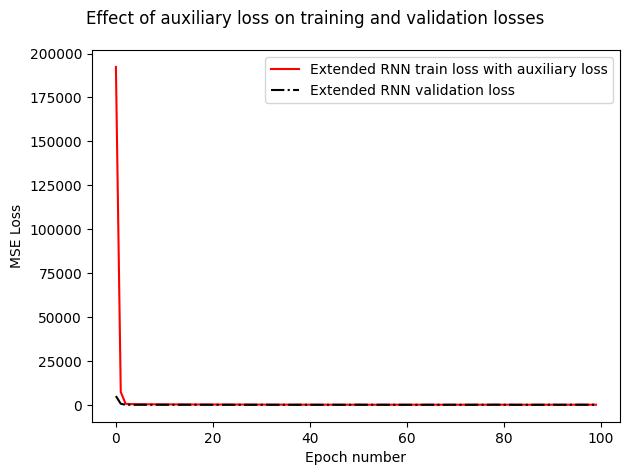

In [51]:
plt.plot(epochs_xaxis, aux_train_losses_beta, color = 'r', linestyle = '-', label = "Extended RNN train loss with auxiliary loss")
plt.plot(epochs_xaxis, aux_val_losses_beta, color = 'k', linestyle = '-.', label = "Extended RNN validation loss")
plt.xlabel('Epoch number')
plt.ylabel('MSE Loss')
plt.suptitle("Effect of auxiliary loss on training and validation losses")
plt.tight_layout()
plt.legend()
plt.plot()

In [53]:
print("final validation loss for auxiliary loss extended rnn:", aux_val_losses_beta[-1])

final validation loss for auxiliary loss extended rnn: 50.42962233225504


The auxiliary loss doesn't help here given too high final validation loss of around 50. I won't worry as reassured above

__Exercise 5.2__: (7 marks)
* In order to implement train an RNN model which includes the __inter-aux-loss__, a new dataset object and Pytorch model class must be defined. These have been started for you below however, you need to complete the code blocks.

_Hint_:
* This model _should_ perform the best!
* ```PandasTsDataset1StepAux```:
    * The dataset class requires an additional input namely a pandas dataframe ```y_1_step``` that should contain the 1 step values
    * The only change that needs to be made is to the ```get_lookback``` method however, the method still only adds values to the ```self._y``` and ```self._X```. How might the ```self.y_1_step``` tensor be incorporated?
* ```AugInterAuxRNN```:
    * In the ```forward``` method of the ```ExtendedRNN```, the logic ```if not self.training:``` defines how the forward pass is altered when ```model.eval()``` is called (this is called within the ```validate``` function at the beginning of the notebook).
    * Note that in the experiment definintion below, a dataset of type ```PandasTsDataset1StepAux``` is used to define the training dataset whilst a dataset of type ```PandasTsDataset``` is used to define the validation set. How should the model output alter to adjust to this?

In [57]:
class PandasTsDataset1StepAux(PandasDataset):
    def __init__(self, X:pd.DataFrame, y:pd.DataFrame, y_1_step:pd.DataFrame, lookback:int, normalise:bool=True)->None:
        self.y_1_step = torch.from_numpy(y_1_step.values).float()
        # Call super so that the PandasDataset.__init__ function is called
        super().__init__(X=X, y=y, normalise=normalise)
        if lookback > 1:
            self.get_lookback(lookback=lookback)
        self._len = self._X.shape[0]


    def get_lookback(self, lookback:int):
        X_vals = []
        y_vals = []
        # Your code here
        for i in range(self._X.shape[0]-(lookback-1)):
            X_vals.append(self._X[i:i+lookback][None, :])
            y_vals.append(torch.cat((self.y_1_step[i+lookback-1:i+lookback],
                                     self._y[i + lookback-1:i+lookback]), dim=1))

        # Your code here - END
        self._y = torch.concat(y_vals, axis=0)
        self._X = torch.concat(X_vals, axis=0)


class AugInterAuxRNN(ExtendedRNN):

    def __init__(
        self, input_dim:int,  rnn_hidden_dim:int, rnn_num_layers:int,
        fc_head_layers:List[int], fc_inter_head_layers:List[int],
        nonlinearity:str
    ) -> None:
        super().__init__(
            input_dim=input_dim, rnn_hidden_dim=rnn_hidden_dim,
            rnn_num_layers=rnn_num_layers, fc_head_layers=fc_head_layers,
            nonlinearity=nonlinearity
        )
        self.fc_inter = nn.ModuleList()
        fc_inter_head_layers = [hidden_dim, *fc_inter_head_layers]
        for i in range(len(fc_inter_head_layers)-1):
            self.fc_inter.append(nn.Linear(
                in_features=fc_inter_head_layers[i],
                out_features=fc_inter_head_layers[i+1]
            ))
            if i != len(fc_inter_head_layers)-1:
                self.fc_inter.append(self.fc_non_linear)

    def forward(self, x):
        # Your code here
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out = self.rnn(x, hidden)
        out = out[1].squeeze()
        for layer in self.fc:
            out = layer(out)
        if not self.training:
            if len(out.shape) == 1:
            # there is an uneven number of datapoints for batch = 2, so handle the case where
            # the last batch is of dimension 1 during validation
                out = out[0][:, None]
            else:
                out = out[:,0][:, None]
        return out
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self._num_layers, batch_size, self._hidden_dim)
        return hidden
        # Your code here - END

In [59]:
input_dim = 4
lr = 0.001
lookback = 2
hidden_dim = 64
num_layers = 1
fc_head_layers = [32,1]
fc_inter_head_layers = [32,1]
nonlinearity = "relu"
shuffle = True
batch_size = 32
epochs = 100

trgt_cols = ["meantemp_5_step"]
display(train_df[non_date_vars+trgt_cols+["meantemp_1_step"]].head())
train_dataset = PandasTsDataset1StepAux(
    X=train_df[non_date_vars],
    y = train_df[trgt_cols],
    y_1_step=train_df[["meantemp_1_step"]],
    lookback=2,
    normalise=True # Set this to true to stabilize the output of the RNN
)
train_loader = DataLoader(dataset=train_dataset, shuffle=shuffle, batch_size=batch_size)
print(f"First observation X:\n{train_dataset[0][1]}")
print(f"First observation y:\n{train_dataset[0][0]}")
print("\n")

print(f"Second observation X:\n{train_dataset[1][1]}")
print(f"Second observation y:\n{train_dataset[1][0]}")

val_idx = val_df[trgt_cols].isna().sum(axis=1) == 0
val_dataset = PandasTsDataset(X=val_df[val_idx][non_date_vars], y=val_df[val_idx][trgt_col], lookback=lookback)
val_loader = DataLoader(dataset=val_dataset, shuffle=shuffle, batch_size=batch_size)

wandb_config={
    "lr": lr,
    "lookback": lookback,
    "hidden_dim": hidden_dim,
    "num_layers": num_layers,
    "fc_head_layers": fc_head_layers,
    "fc_inter_head_layers": fc_inter_head_layers,
    "nonlinearity": nonlinearity
}

model = AugInterAuxRNN(
    input_dim=input_dim, rnn_hidden_dim=wandb_config["hidden_dim"],
    rnn_num_layers=wandb_config["num_layers"],
    fc_head_layers=wandb_config["fc_head_layers"],
    fc_inter_head_layers=wandb_config["fc_inter_head_layers"],
    nonlinearity=wandb_config["nonlinearity"]
)

# Check model is predicting
with torch.no_grad():
    model.train()
    first_batch = next(train_loader.__iter__())
    res = model(first_batch[1])
    print(f"first_batch res shape: {first_batch[0].shape}")
    print(f"res shape: {res.shape}")

    model.eval()
    first_batch = next(val_loader.__iter__())
    res = model(first_batch[1])
    print(f"first_batch res shape: {first_batch[0].shape}")
    print(f"res shape: {res.shape}")

optimizer=torch.optim.Adam(model.parameters(), lr=wandb_config["lr"])
epoch_train_loss, epoch_val_loss = train(
    model=model, train_data_loader=train_loader, val_data_loader=val_loader, gpu = gpu,
    optimizer=optimizer, criterion=ovrl_criterion, epochs=epochs,
    wandb_proj=WANDB_PROJ, wandb_name="inter-aug-aux-rnn", wandb_config=wandb_config, debug=False
)

,meantemp,humidity,wind_speed,meanpressure,meantemp_5_step,meantemp_1_step
0,10.000000,84.500000,0.000000,1015.666667,7.000000,7.400000
1,7.400000,92.000000,2.980000,1017.800000,7.000000,7.166667
2,7.166667,87.000000,4.633333,1018.666667,8.857143,8.666667
3,8.666667,71.333333,1.233333,1017.166667,14.000000,6.000000
4,6.000000,86.833333,3.700000,1016.500000,11.000000,7.000000


First observation X:
tensor([[0.1223, 0.8404, 0.0000, 0.7681],
        [0.0428, 0.9291, 0.0706, 0.8356]])
First observation y:
tensor([7.1667, 7.0000])


Second observation X:
tensor([[0.0428, 0.9291, 0.0706, 0.8356],
        [0.0357, 0.8699, 0.1097, 0.8630]])
Second observation y:
tensor([8.6667, 8.8571])
first_batch res shape: torch.Size([32, 2])
res shape: torch.Size([32, 1])
first_batch res shape: torch.Size([32, 1])
res shape: torch.Size([32, 1])


Running training epoch


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
25it [00:00, 239.07it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([6, 2])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
35it [00:00, 226.07it/s]
12it [00:00, 816.29it/s]


Running validation
Running training epoch


35it [00:00, 199.62it/s]
12it [00:00, 667.47it/s]


Running validation
Running training epoch


35it [00:00, 322.46it/s]
12it [00:00, 445.86it/s]


Running validation
Running training epoch


35it [00:00, 206.03it/s]
12it [00:00, 613.08it/s]


Running validation
Running training epoch


35it [00:00, 292.71it/s]
12it [00:00, 901.76it/s]


Running validation
Running training epoch


35it [00:00, 257.70it/s]
12it [00:00, 640.15it/s]


Running validation
Running training epoch


35it [00:00, 213.27it/s]
12it [00:00, 958.37it/s]


Running validation
Running training epoch


35it [00:00, 356.81it/s]
12it [00:00, 823.64it/s]


Running validation
Running training epoch


35it [00:00, 283.79it/s]
12it [00:00, 586.36it/s]


Running validation
Running training epoch


35it [00:00, 282.08it/s]
12it [00:00, 837.99it/s]


Running validation
Running training epoch


35it [00:00, 247.38it/s]
12it [00:00, 758.29it/s]


Running validation
Running training epoch


35it [00:00, 332.08it/s]
12it [00:00, 637.94it/s]


Running validation
Running training epoch


35it [00:00, 188.26it/s]
12it [00:00, 547.39it/s]


Running validation
Running training epoch


35it [00:00, 214.38it/s]
12it [00:00, 624.55it/s]


Running validation
Running training epoch


35it [00:00, 234.36it/s]
12it [00:00, 591.00it/s]


Running validation
Running training epoch


35it [00:00, 239.41it/s]
12it [00:00, 667.60it/s]


Running validation
Running training epoch


35it [00:00, 235.31it/s]
12it [00:00, 371.65it/s]


Running validation
Running training epoch


35it [00:00, 195.73it/s]
12it [00:00, 579.90it/s]


Running validation
Running training epoch


35it [00:00, 237.45it/s]
12it [00:00, 529.71it/s]


Running validation
Running training epoch


35it [00:00, 223.74it/s]
12it [00:00, 592.24it/s]


Running validation
Running training epoch


35it [00:00, 212.62it/s]
12it [00:00, 593.46it/s]


Running validation
Running training epoch


35it [00:00, 170.84it/s]
12it [00:00, 674.10it/s]


Running validation
Running training epoch


35it [00:00, 231.16it/s]
12it [00:00, 682.81it/s]


Running validation
Running training epoch


35it [00:00, 210.29it/s]
12it [00:00, 674.24it/s]


Running validation
Running training epoch


35it [00:00, 224.35it/s]
12it [00:00, 473.80it/s]


Running validation
Running training epoch


35it [00:00, 214.29it/s]
12it [00:00, 646.80it/s]


Running validation
Running training epoch


35it [00:00, 202.18it/s]
12it [00:00, 649.14it/s]


Running validation
Running training epoch


35it [00:00, 218.28it/s]
12it [00:00, 484.21it/s]


Running validation
Running training epoch


35it [00:00, 234.07it/s]
12it [00:00, 510.44it/s]


Running validation
Running training epoch


35it [00:00, 232.17it/s]
12it [00:00, 521.82it/s]


Running validation
Running training epoch


35it [00:00, 215.73it/s]
12it [00:00, 524.66it/s]


Running validation
Running training epoch


35it [00:00, 224.02it/s]
12it [00:00, 449.98it/s]


Running validation
Running training epoch


35it [00:00, 209.97it/s]
12it [00:00, 634.61it/s]


Running validation
Running training epoch


35it [00:00, 220.37it/s]
12it [00:00, 638.14it/s]


Running validation
Running training epoch


35it [00:00, 211.99it/s]
12it [00:00, 670.84it/s]


Running validation
Running training epoch


35it [00:00, 189.86it/s]
12it [00:00, 541.28it/s]


Running validation
Running training epoch


35it [00:00, 220.21it/s]
12it [00:00, 531.72it/s]


Running validation
Running training epoch


35it [00:00, 218.47it/s]
12it [00:00, 590.08it/s]


Running validation
Running training epoch


35it [00:00, 212.85it/s]
12it [00:00, 597.29it/s]


Running validation
Running training epoch


35it [00:00, 205.27it/s]
12it [00:00, 646.05it/s]


Running validation
Running training epoch


35it [00:00, 163.96it/s]
12it [00:00, 486.01it/s]


Running validation
Running training epoch


35it [00:00, 193.92it/s]
12it [00:00, 430.56it/s]


Running validation
Running training epoch


35it [00:00, 211.60it/s]
12it [00:00, 526.72it/s]


Running validation
Running training epoch


35it [00:00, 203.21it/s]
12it [00:00, 551.48it/s]


Running validation
Running training epoch


35it [00:00, 223.39it/s]
12it [00:00, 543.97it/s]


Running validation
Running training epoch


35it [00:00, 198.67it/s]
12it [00:00, 511.01it/s]


Running validation
Running training epoch


35it [00:00, 224.50it/s]
12it [00:00, 576.90it/s]


Running validation
Running training epoch


35it [00:00, 222.02it/s]
12it [00:00, 548.36it/s]


Running validation
Running training epoch


35it [00:00, 229.87it/s]
12it [00:00, 615.08it/s]


Running validation
Running training epoch


35it [00:00, 210.80it/s]
12it [00:00, 499.00it/s]


Running validation
Running training epoch


35it [00:00, 232.44it/s]
12it [00:00, 621.39it/s]


Running validation
Running training epoch


35it [00:00, 228.30it/s]
12it [00:00, 648.39it/s]


Running validation
Running training epoch


35it [00:00, 232.11it/s]
12it [00:00, 501.36it/s]


Running validation
Running training epoch


35it [00:00, 228.42it/s]
12it [00:00, 466.85it/s]


Running validation
Running training epoch


35it [00:00, 236.46it/s]
12it [00:00, 475.55it/s]


Running validation
Running training epoch


35it [00:00, 221.01it/s]
12it [00:00, 702.36it/s]


Running validation
Running training epoch


35it [00:00, 218.32it/s]
12it [00:00, 603.63it/s]


Running validation
Running training epoch


35it [00:00, 223.74it/s]
12it [00:00, 485.85it/s]


Running validation
Running training epoch


35it [00:00, 201.52it/s]
12it [00:00, 631.57it/s]


Running validation
Running training epoch


35it [00:00, 221.06it/s]
12it [00:00, 564.64it/s]


Running validation
Running training epoch


35it [00:00, 227.13it/s]
12it [00:00, 607.22it/s]


Running validation
Running training epoch


35it [00:00, 254.61it/s]
12it [00:00, 662.26it/s]


Running validation
Running training epoch


35it [00:00, 205.45it/s]
12it [00:00, 554.87it/s]


Running validation
Running training epoch


35it [00:00, 193.75it/s]
12it [00:00, 649.05it/s]


Running validation
Running training epoch


35it [00:00, 204.52it/s]
12it [00:00, 529.71it/s]


Running validation
Running training epoch


35it [00:00, 220.22it/s]
12it [00:00, 567.67it/s]


Running validation
Running training epoch


35it [00:00, 209.00it/s]
12it [00:00, 619.47it/s]


Running validation
Running training epoch


35it [00:00, 213.98it/s]
12it [00:00, 606.73it/s]


Running validation
Running training epoch


35it [00:00, 198.70it/s]
12it [00:00, 447.01it/s]


Running validation
Running training epoch


35it [00:00, 178.44it/s]
12it [00:00, 531.24it/s]


Running validation
Running training epoch


35it [00:00, 197.38it/s]
12it [00:00, 617.95it/s]


Running validation
Running training epoch


35it [00:00, 247.08it/s]
12it [00:00, 874.15it/s]


Running validation
Running training epoch


35it [00:00, 302.86it/s]
12it [00:00, 868.66it/s]


Running validation
Running training epoch


35it [00:00, 309.10it/s]
12it [00:00, 863.57it/s]


Running validation
Running training epoch


35it [00:00, 293.99it/s]
12it [00:00, 857.83it/s]


Running validation
Running training epoch


35it [00:00, 298.64it/s]
12it [00:00, 649.42it/s]


Running validation
Running training epoch


35it [00:00, 286.85it/s]
12it [00:00, 583.89it/s]


Running validation
Running training epoch


35it [00:00, 273.77it/s]
12it [00:00, 720.83it/s]


Running validation
Running training epoch


35it [00:00, 323.02it/s]
12it [00:00, 829.08it/s]


Running validation
Running training epoch


35it [00:00, 295.20it/s]
12it [00:00, 722.01it/s]


Running validation
Running training epoch


35it [00:00, 210.86it/s]
12it [00:00, 609.15it/s]


Running validation
Running training epoch


35it [00:00, 334.39it/s]
12it [00:00, 827.70it/s]


Running validation
Running training epoch


35it [00:00, 305.92it/s]
12it [00:00, 748.76it/s]


Running validation
Running training epoch


35it [00:00, 369.13it/s]
12it [00:00, 717.75it/s]


Running validation
Running training epoch


35it [00:00, 322.13it/s]
12it [00:00, 857.32it/s]


Running validation
Running training epoch


35it [00:00, 324.35it/s]
12it [00:00, 651.92it/s]


Running validation
Running training epoch


35it [00:00, 294.06it/s]
12it [00:00, 877.52it/s]


Running validation
Running training epoch


35it [00:00, 283.83it/s]
12it [00:00, 878.13it/s]


Running validation
Running training epoch


35it [00:00, 296.62it/s]
12it [00:00, 789.65it/s]


Running validation
Running training epoch


35it [00:00, 331.41it/s]
12it [00:00, 1004.88it/s]


Running validation
Running training epoch


35it [00:00, 338.38it/s]
12it [00:00, 804.11it/s]


Running validation
Running training epoch


35it [00:00, 334.69it/s]
12it [00:00, 1023.88it/s]


Running validation
Running training epoch


35it [00:00, 292.00it/s]
12it [00:00, 659.36it/s]


Running validation
Running training epoch


35it [00:00, 212.54it/s]
12it [00:00, 642.53it/s]


Running validation
Running training epoch


35it [00:00, 223.52it/s]
12it [00:00, 504.34it/s]


Running validation
Running training epoch


35it [00:00, 216.52it/s]
12it [00:00, 467.18it/s]


Running validation
Running training epoch


35it [00:00, 231.31it/s]
12it [00:00, 654.11it/s]


Running validation
Running training epoch


35it [00:00, 208.37it/s]
12it [00:00, 526.88it/s]


Running validation
Running training epoch


35it [00:00, 242.98it/s]
12it [00:00, 623.56it/s]


Running validation
Running training epoch


35it [00:00, 240.34it/s]
12it [00:00, 527.73it/s]


Running validation


train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,5.29853
val_loss,7.21946


In [60]:
inter_aux_train_loss, inter_aux_val_loss =epoch_train_loss, epoch_val_loss

In [65]:
print("minimum validation loss", min(inter_aux_val_loss))
print("at epoch: ", inter_aux_val_loss.index(min(inter_aux_val_loss)))
print("final validation loss: ", inter_aux_val_loss[-1] )

minimum validation loss 6.691141565640767
at epoch:  87
final validation loss:  7.21945850054423


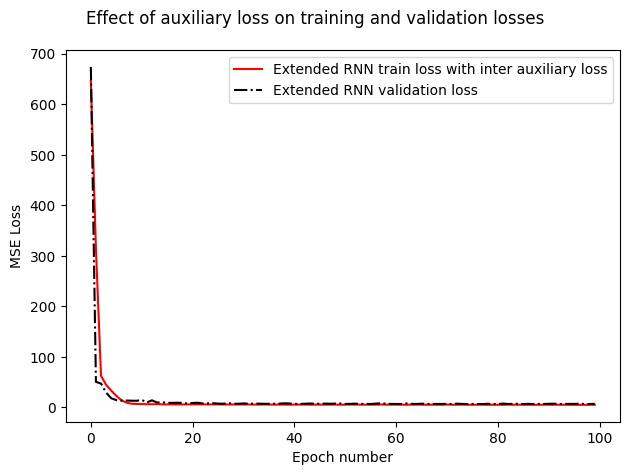

In [62]:
plt.plot(epochs_xaxis, inter_aux_train_loss, color = 'r', linestyle = '-', label = "Extended RNN train loss with inter auxiliary loss")
plt.plot(epochs_xaxis, inter_aux_val_loss, color = 'k', linestyle = '-.', label = "Extended RNN validation loss")
plt.xlabel('Epoch number')
plt.ylabel('MSE Loss')
plt.suptitle("Effect of auxiliary loss on training and validation losses")
plt.tight_layout()
plt.legend()
plt.show()

I get an extremely high validation loss when the training set's normalise flag is set to False. After setting it to true, I get a low validation loss of around 7 (value may vary due to stochasticity). A lookback of 7 or 9 has competitive performance with respect to this auxiliary loss.